# Examine the dynamics of viral escape from each antibody

## Import Python modules

In [1]:
import os
import sys
import glob
import random
from collections import defaultdict
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.colors import TwoSlopeNorm
%matplotlib inline
import seaborn as sns
sns.set_theme(font_scale=1.0, style='ticks', palette='colorblind')

import scipy.stats
from sklearn.cluster import KMeans
from scipy.spatial.distance import squareform, pdist, cdist
#import hdbscan
#import umap

#from Bio import SeqIO
import dmslogo

# Import custom script
sys.path.append('../scripts/')
import clusters

# Make figures directory
if not os.path.isdir('../results/figures_v2/'):
    os.makedirs('../results/figures_v2/')

## Read in data

Read in escape scores and DMS data

In [2]:
# Read in mutation-level DMS data from Cao et al. and compute normalized
# mutation-level escape scores
dms_df = (
    pd.read_csv('../convergent_RBD_evolution/use_res_clean.csv')
    .assign(site_escape = lambda x: x.groupby(['antibody', 'site'])['mut_escape'].transform(sum))
    .assign(max_site_escape = lambda x: x.groupby('antibody')['site_escape'].transform(max))
    .assign(normalized_mut_escape = lambda x: x['mut_escape'] / x['max_site_escape'])
    .rename(columns={'group' : 'epitope_cluster'})
)

# Make a shorter version of the above dataframe giving the epitope group of each ab
ab_group_df = dms_df.drop_duplicates('antibody')[['antibody', 'epitope_cluster']]

# Read in site-level escape scores
escape_calc_resultsdir = '../results/processed_input_data/'
site_escape_df = pd.read_csv(os.path.join(escape_calc_resultsdir, 'escape.csv'))

# Read in estimated escape scores for antibodies from Cao et al. and merge with data
# giving epitope groups
escape_scores_df = pd.read_csv('../results/predicted_escape_scores_v2/all_predictions.csv')
escape_scores_df = escape_scores_df.merge(ab_group_df, how='left')
escape_scores_df['epitope_cluster'].fillna('other', inplace=True)
escape_scores_df['escape_score'].clip(upper=1.0, inplace=True)
escape_scores_df['all_aa_substitutions'] = escape_scores_df['all_aa_substitutions'].fillna('')

# Rename some of the Nextstrain clade names, and consolidate the 21A/I/J Delta clades into one
escape_scores_df['clade'] = escape_scores_df['Nextstrain_clade']
escape_scores_df['clade'] = escape_scores_df['clade'].replace({
    '20E (EU1)' : '20E',
    '20H (Beta, V2)' : '20H (Beta)',
    '20I (Alpha, V1)' : '20I (Alpha)',
    '20J (Gamma, V3)' : '20J (Gamma)',
    '21A (Delta)' : '21A/I/J (Delta)',
    '21I (Delta)' : '21A/I/J (Delta)',
    '21J (Delta)' : '21A/I/J (Delta)',
    '21K (Omicron)' : '21K (BA.1)',
    '21L (Omicron)' : '21L (BA.2)',
    '22A (Omicron)' : '22A (BA.4)',
    '22B (Omicron)' : '22B (BA.5)',
    '22C (Omicron)' : '22C (BA.2.12.1)',
    '22D (Omicron)' : '22D (BA.2.75)',
    '22E (Omicron)' : '22E (BQ.1)',
    '22F (Omicron)' : '22F (XBB)',
    '23A (Omicron)' : '23A (XBB.1.5)',
    '23B (Omicron)' : '23B (XBB.1.16)',
    '23D (Omicron)' : '23D (XBB.1.9)',
    '23E (Omicron)' : '23E (XBB.2.3)',
})
def get_short_clade_name(x):
    return x.split(' ')[0]
escape_scores_df['clade_short'] = escape_scores_df['clade'].apply(lambda x: get_short_clade_name(x))

abs_with_predictions = escape_scores_df["antibody"].unique()
print(f'Read in predicted escape scores for {len(abs_with_predictions)} antibodies')

Read in predicted escape scores for 1609 antibodies


Read in estimated fitness effects of amino-acid mutations.

In [3]:
# # Read in data
# f = '/fh/fast/matsen_e/hhaddox/2024/SARS2-synonymous-mut-rate/SARS2-mut-fitness/results_gisaid_2024-04-24/aa_fitness/aamut_fitness_by_clade.csv'
# fitness_df = pd.read_csv(f)

# # Consolidate the Delta clades using the same strategy as in the dataframe of escape scores
# # TODO: update with new fitness estimates
# fitness_df['clade'] = fitness_df['clade'].replace({
#     #'21A' : '21A',
#     '21I' : '21I/J',
#     '21J' : '21I/J',
# })
# fitness_df = fitness_df.groupby(['clade', 'gene', 'aa_mutation'], as_index=False).agg(
#     delta_fitness = pd.NamedAgg('delta_fitness', 'mean'),
#     actual_count = pd.NamedAgg('actual_count', 'sum'),
#     expected_count = pd.NamedAgg('expected_count', 'sum'),
# )

# # Merge with clade names in the dataframe of escape scores
# fitness_df.rename(columns={'clade':'clade3'}, inplace=True)
# clade3_df = escape_scores_df.drop_duplicates('clade')[['clade', 'clade3']]
# fitness_df = fitness_df.merge(clade3_df, on='clade3', how='left')

Read in IC50 data

In [4]:
# Read in IC50 data from Cao et al.
ic50s_df = pd.read_csv(os.path.join(
    escape_calc_resultsdir, 'antibody_IC50s.csv'
))
ic50s_df['study'] = 'Cao et al.'

# Read in IC50 data from Wang et al.
cols = [
    'antibody', 'Spike', 'RBD', 'NTD',
    'av_D614G', 'av_Beta', 'av_Gamma', 'av_Delta', 'av_Omicron',
    'pv_D614G', 'pv_Alpha', 'pv_Beta', 'pv_Gamma', 'pv_Delta',
    'pv_Lamda', 'pv_Omicron',
    'BLI'
]
wang_ic50s_df = pd.read_excel('../data/Wang_ic50_values.xlsx', skiprows=3, names=cols)
wang_ic50s_df = (
    wang_ic50s_df[
        (wang_ic50s_df['antibody'].str.contains('data referenced') == False)
    ]
    .dropna(subset='antibody')
    .replace('>50', '50')
    .replace('>10', 10)
    .replace('NS', np.nan)
    .replace('-', np.nan)
)
wang_ic50s_df['antibody'] = wang_ic50s_df['antibody'].apply(
    lambda x: x.replace('*', '').replace('XGv', 'XGv-')
)

# For Wang et al., record IC50s for both authentic virus (av) and pseudovirus (pv)
dfs = [ic50s_df]
for virus_type in ['av', 'pv']:
    vt_cols = [col for col in wang_ic50s_df if virus_type in col]
    vt_ic50s_df = wang_ic50s_df[['antibody']+vt_cols].copy()
    vt_ic50s_df.rename(columns={
        col : col.replace(f'{virus_type}_', '')
        for col in vt_ic50s_df
    }, inplace=True)
    value_vars = [col for col in vt_ic50s_df if col != 'antibody']
    vt_ic50s_df = vt_ic50s_df.melt(
        id_vars='antibody', value_vars=value_vars,
        var_name='virus', value_name='IC50'
    )
    vt_ic50s_df['IC50'] = vt_ic50s_df['IC50'].astype(float)
    vt_ic50s_df['study'] = f'Wang et al. {virus_type}'
    vt_ic50s_df['virus'].replace({
        'Omicron':'BA.1',
        'Lamda':'Lambda',
    }, inplace=True)
    dfs.append(vt_ic50s_df)
    
ic50s_df = pd.concat(dfs)
ic50s_df['log_IC50'] = ic50s_df['IC50'].apply(lambda x: np.log10(x))

# Merge with data on antibody source and antibody group, and subset to antibodies
# with predicted escape scores
ab_source_df = pd.read_csv(os.path.join(escape_calc_resultsdir, 'antibody_sources.csv'))
ic50s_df = (
    ic50s_df[ic50s_df['antibody'].isin(abs_with_predictions)]
    .merge(
        ab_source_df[ab_source_df['study'] == 'imprinted_2022'][['antibody', 'source']],
        on='antibody', how='left'
    )
    .merge(ab_group_df, on='antibody', how='left')
)

# For each antibody from each study, compute the change in log IC50 value for a
# given virus relative to the D614G virus
init_data = (
    ic50s_df[ic50s_df['virus'] == 'D614G'][['antibody', 'study', 'log_IC50']]
    .copy()
    .rename(columns={'log_IC50':'init_log_IC50'})
)
if 'init_log_IC50' not in ic50s_df.columns.values:
    ic50s_df = ic50s_df.merge(
        init_data, on=['antibody', 'study'], how='left', validate='many_to_one'
    )
    ic50s_df['delta_log_IC50'] = ic50s_df['log_IC50'] - ic50s_df['init_log_IC50']


# Make a dataframe with IC50s against D614G
init_ic50s_df = ic50s_df[
    (ic50s_df['virus'] == 'D614G') &
    (ic50s_df['study'] == 'Cao et al.')
].copy()
init_ic50s_df['IC50_weight'] = init_ic50s_df['IC50'].apply(lambda x: -np.log10(x/10))

print('Read in IC50 data for this many antibodies from each study')
display(ic50s_df.drop_duplicates(['study', 'antibody'])['study'].value_counts())

print('This many antibodies came from each of the following groups of patients')
display(ic50s_df.drop_duplicates('antibody')['source'].value_counts().loc[['WT vaccinees', 'WT convalescents', 'BA.1 convalescents', 'BA.2 convalescents', 'BA.5 convalescents']])

Read in IC50 data for this many antibodies from each study


Cao et al.        1603
Wang et al. av      90
Wang et al. pv      90
Name: study, dtype: int64

This many antibodies came from each of the following groups of patients


WT vaccinees          205
WT convalescents      321
BA.1 convalescents    462
BA.2 convalescents    470
BA.5 convalescents    145
Name: source, dtype: int64

In [5]:
print(
    ic50s_df
    .drop_duplicates('antibody')[['source']]
    .value_counts()
    .loc[['WT vaccinees', 'WT convalescents', 'BA.1 convalescents', 'BA.2 convalescents', 'BA.5 convalescents']]
    .to_latex(label='sources', column_format='cc')
)

\begin{table}
\centering
\label{sources}
\begin{tabular}{cc}
\toprule
                   &    0 \\
source &      \\
\midrule
WT vaccinees &  205 \\
WT convalescents &  321 \\
BA.1 convalescents &  462 \\
BA.2 convalescents &  470 \\
BA.5 convalescents &  145 \\
\bottomrule
\end{tabular}
\end{table}



/tmp/ipykernel_6145/228768232.py:6: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  .to_latex(label='sources', column_format='cc')


## Compute how escape scores, mutation frequencies, and clade frequencies change over time

In a sliding window of 0.2 years that tiles across the phylogeny of viruses, we take all viruses within the window and compute the following things:
* for each antibody, the average escape score of each virus for that antibody. The resulting sliding-window average defines the virus's escape trajectory.
* the frequency of mutations at sites of escape in the RBD protein sequence 
* the frequency of clades

In [6]:
# Define parameters of sliding windows
start_time = escape_scores_df['year'].min()
end_time = escape_scores_df['year'].max()
window_width = 0.2
window_step_size = 0.1

# Make a list of sliding windows, recording the time corresponding to the left
# side of each window
left_side_of_window = start_time
list_of_left_sides_of_windows = []
while left_side_of_window <= end_time:
    list_of_left_sides_of_windows.append(left_side_of_window)
    left_side_of_window = left_side_of_window + window_step_size

# Get a list of all sites with mutations
all_mut_sites = []
all_subs = set(escape_scores_df[
    escape_scores_df['all_aa_substitutions'].notnull()
]['all_aa_substitutions'])
for subs in all_subs:
    if subs == '':
        continue
    subs = subs.split(' ')
    for sub in subs:
        all_mut_sites.append(int(sub[1:-1]))
all_mut_sites = sorted(list(set(all_mut_sites)))

# Initiate a series with zero counts for each clade
clade_zeros_dict = {
    clade : 0
    for clade in escape_scores_df['clade'].unique()
}
clade_zeros_series = pd.Series(clade_zeros_dict)
clade_freqs_dict = defaultdict(list)

# For each window:
# i) for each antibody, record the average escape score of all viruses within each window
# ii) record the frequency of mutations at each site
# iii) record the frequency of each clade
mut_freq_dict = defaultdict(list)
dfs = []
for left_side_of_window in list_of_left_sides_of_windows:

    right_side_of_window = left_side_of_window + window_width
    center_of_window = left_side_of_window + (window_width / 2)
       
    # Get data for all viruses in the window, and then compute their mean escape score
    # relative to each antibody
    data = (
        escape_scores_df[(escape_scores_df['year'].between(left_side_of_window, right_side_of_window))]
        .groupby(['antibody', 'epitope_cluster'], as_index=False)['escape_score'].mean(numeric_only=True)
        .assign(time=center_of_window-start_time)
        .assign(year=center_of_window)
    )
    dfs.append(data)

    # Get data for all unique viruses within a given window then record the frequency of
    # each mutation
    data = escape_scores_df[
        (escape_scores_df['year'].between(left_side_of_window, right_side_of_window))
    ].drop_duplicates('strain').copy()
    data['all_aa_substitutions'].fillna('', inplace=True)
    for mut_site in all_mut_sites:
        mut_freq_dict['time'].append(center_of_window-start_time)
        mut_freq_dict['year'].append(center_of_window)
        mut_freq_dict['site'].append(mut_site)
        mut_freq_dict['mut_freq'].append(
            sum(data['all_aa_substitutions'].str.contains(r'\D{0}\D'.format(mut_site))) / len(data)
        )

    # ... also record clade frequencies
    clade_counts = (data['clade'].value_counts() + clade_zeros_series).fillna(0)
    clade_freqs = clade_counts / clade_counts.sum()
    for (clade, freq) in clade_freqs.items():
        clade_freqs_dict['clade'].append(clade)
        clade_freqs_dict['freq'].append(freq)
        clade_freqs_dict['time'].append(center_of_window-start_time)
        clade_freqs_dict['year'].append(center_of_window)
           
# Compile escape trajectories
traj_df = pd.concat(dfs)
traj_df.rename(columns={'escape_score' : 'mean_escape'}, inplace=True)

# Add columns to escape_df that give antibody metadata relative to the D614G strain
traj_df = traj_df.merge(
    init_ic50s_df[['antibody', 'IC50', 'IC50_weight', 'log_IC50', 'source']],
    on='antibody', how='left'
)
traj_df['wtd_escape_score'] = traj_df['mean_escape'] * traj_df['IC50_weight']

# Complie the frequencies of mutations and clades over time
mut_freq_df = pd.DataFrame(mut_freq_dict)
clade_freqs_df = pd.DataFrame(clade_freqs_dict)

Plot the change in escape score over time, averaged across all antibodies

Showing data from these sources: ['WT convalescents', 'WT vaccinees', 'BA.1 convalescents', 'BA.2 convalescents', 'BA.5 convalescents']


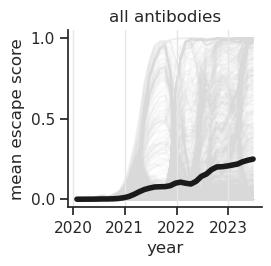

In [7]:
# Plot total escape over time
sources = [
    'WT convalescents', 'WT vaccinees',
    'BA.1 convalescents', 'BA.2 convalescents', 'BA.5 convalescents',
]
print('Showing data from these sources:', sources)
metric = 'mean_escape' # 'wtd_escape_score' # 
data = (
    traj_df[traj_df['source'].isin(sources)]
    .groupby('year', as_index=False)[[metric]].mean()
)
#data[metric] = data[metric] / data[metric].max()
plt.figure(figsize=[2.5,2.3])
sns.lineplot(x='year', y=metric, data=data, linewidth=4, color='k')
data = traj_df[traj_df['source'].isin(sources)]
sns.lineplot(
    data=data, x="year", y="mean_escape", units='antibody',
    estimator=None, color=".85", linewidth=1, zorder=0, alpha=0.1
)
plt.grid(axis='x', color='0.9')
plt.title('all antibodies')
plt.yticks([0, 0.5, 1.0])
plt.ylabel('mean escape score')
sns.despine()
# plt.savefig(f'../results/figures/average_trajectory_all_antibodies.png', dpi=300, bbox_inches='tight')
plt.show()

Show the escape trajectory for a single antibody of interest

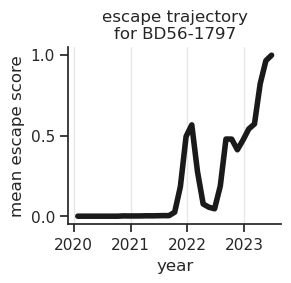

In [8]:
antibody_to_plot = 'BD56-1797' # 'LY-CoV555' # 'BD-744'
data = traj_df[traj_df['antibody'] == antibody_to_plot]
plt.figure(figsize=[2.75,2.3])
sns.lineplot(x='year', y='mean_escape', data=data, linewidth=4, color='k')
plt.grid(axis='x', color='0.9')
plt.title(f'escape trajectory\nfor {antibody_to_plot}')
plt.yticks([0, 0.5, 1.0])
plt.ylabel('mean escape score')
sns.despine()
# plt.savefig(f'../results/figures/trajectory_for_{antibody_to_plot}.png', dpi=300, bbox_inches='tight')
plt.show()

Show the DMS data for the antibody from above

In [9]:
# # Get DMS data
# antibody_to_plot = 'BD56-1797' # 'C1A-B12' # 'BD55-1374' # 
# data = dms_df[dms_df['antibody'] == antibody_to_plot].copy()

# # Add entries of zero for sites with missing data (different antibodies
# # have data for different subsets of sites; we assume that sites with
# # missing data do not have strong escape mutations)
# min_site = dms_df['site'].min()
# max_site = dms_df['site'].max()
# print(min_site, max_site)
# missing_data = defaultdict(list)
# sites_with_data = list(data['site'])
# for site in range(min_site, max_site+1):
#     if site not in sites_with_data:
#         missing_data['site'].append(site)
#         missing_data['mutation'].append('A')
#         missing_data['mut_escape'].append(0)
# missing_data = pd.DataFrame(missing_data)
# data = pd.concat([data, missing_data])
# data['color'] = '0.5'
# data['antibody'] = antibody_to_plot

# # Compute site-level scores
# site_data = (
#     data
#     .groupby('site', as_index=False)[['mut_escape']]
#     .sum()
#     .rename(columns={'mut_escape' : 'site_mut_escape'})
# )
# data = data.merge(site_data, on='site', how='left')
# data.sort_values('site', inplace=True)
# data['normalized_mut_escape'] = data['mut_escape'] / data['site_mut_escape'].max()
# data['normalized_site_mut_escape'] = data['site_mut_escape'] / data['site_mut_escape'].max()

# # Select which sites to plot
# sites_to_plot = list(site_data[site_data['site_mut_escape'] > 1]['site'])
# data['show_site'] = data['site'].isin(sites_to_plot)

# (fig, axs) = plt.subplots(ncols=2, figsize=[12,3])

# _ = dmslogo.draw_logo(
#     data[data['show_site'] == True],
#     x_col="site",
#     letter_col="mutation",
#     letter_height_col="mut_escape",
#     color_col='color',
#     axisfontscale=1,
#     ax=axs[0],
#     ylabel='escape score',
#     title='mutation-level escape scores ($e_{a,r,m}$)\n for a subset of sites'
#     #xtick_col="site_label",
# )

# _ = dmslogo.draw_line(
#     data,
#     x_col="site",
#     height_col="normalized_site_mut_escape",
#     #xtick_col="site",
#     show_col="show_site",
#     axisfontscale=1,
#     ax=axs[1],
#     ylabel='',
#     title='normalized site-level\nescape scores ($x_{a,r}$)'
# )
# axs[1].set(yticks=[0, 0.5, 1])
# plt.suptitle(f'DMS data on escape of the Wuhan-Hu-1 RBD\nfrom antibody {antibody_to_plot} (Cao et al.)', y=1.35, fontsize=17)
# ## plt.savefig(f'../results/figures/dms_data_for_{antibody_to_plot}.png', dpi=300, bbox_inches='tight')
# plt.show()

In [10]:
# antibody_subset = site_escape_df[
#     (site_escape_df['escape_cluster'] == 6) &
#     (site_escape_df['site'] == 446) &
#     (site_escape_df['normalized_escape'] > 0.2)
# ]['antibody'].unique()
# ic50s_df[
#     (ic50s_df['antibody'].isin(antibody_subset)) &
#     (ic50s_df['escape_score'] > 0.8) &
#     (ic50s_df['virus'] == 'BQ.1.1')
# ].head()

How many times does a site have data for at least one mutation across all antibodies?

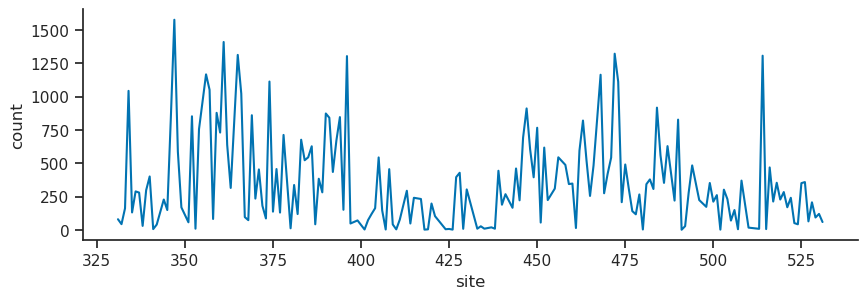

In [11]:
data = dms_df.drop_duplicates(subset=['site', 'antibody'])['site'].value_counts().reset_index()
data.columns = ['site', 'count']
plt.figure(figsize=[10,3])
sns.lineplot(x='site', y='count', data=data)
sns.despine()
plt.show()

In [12]:
data['site'].min(), data['site'].max()

(331, 531)

## Cluster antibodies by escape trajectory

In [13]:
# Get data
escape_matrix = (
    traj_df
    .pivot_table(index='antibody', columns='year', values='mean_escape')
    #.clip(upper=0.8)
)

# Cluster trajectories
n_clusters = 20
kmeans = KMeans(n_clusters=n_clusters, random_state=1).fit(escape_matrix)
escape_matrix['kmeans_cluster'] = kmeans.labels_

Use k-means clustering to group antibodies into 20 clusters

In [14]:
# Get data
escape_matrix = traj_df.pivot_table(index='antibody', columns='year', values='mean_escape')

# Cluster trajectories
n_clusters = 20 # 10 # 
kmeans = KMeans(n_clusters=n_clusters, random_state=1).fit(escape_matrix)
escape_matrix['kmeans_cluster'] = kmeans.labels_

# Consolidate the 20 clusters into 10 clusters
manual_clusters = {
    0 : 10,
    1 : 5,
    2 : 3,
    3 : 8,
    4 : 2,
    5 : 1,
    6 : 4,
    7 : 4,
    8 : 2,
    9 : 10,
    10 : 2,
    11 : 1,
    12 : 7,
    13 : 6,
    14 : 4,
    15 : 2,
    16 : 6,
    17 : 9,
    18 : 10,
    19 : 2
}
assert len(manual_clusters) == 20
escape_matrix['escape_cluster'] = escape_matrix['kmeans_cluster'].apply(lambda x: manual_clusters[x])

# Merge cluster data with the escape-trajectory data and IC50 data
if 'kmeans_cluster' not in traj_df.columns.values:
    data_to_merge = escape_matrix.reset_index()[['antibody', 'kmeans_cluster', 'escape_cluster']]
    traj_df = traj_df.merge(data_to_merge, on='antibody', how='left')
    ic50s_df = ic50s_df.merge(data_to_merge, on='antibody', how='left')
    init_ic50s_df = init_ic50s_df.merge(data_to_merge, on='antibody', how='left')
    dms_df = dms_df.merge(data_to_merge, on='antibody', how='inner')
    site_escape_df = site_escape_df.merge(data_to_merge, on='antibody', how='left')

Plot clusters of antibodies. First, plot the 20 clusters from k means clustering

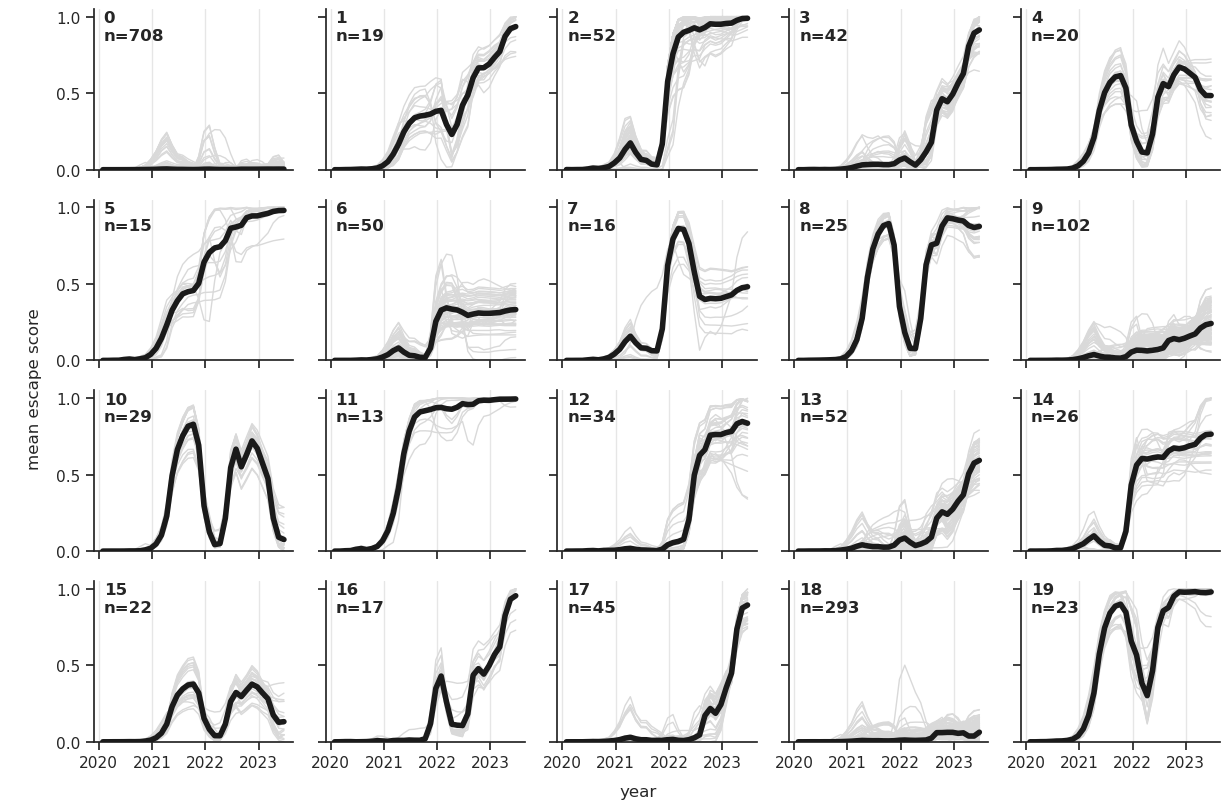

In [15]:
# Plot each antibody group's time series in its own facet
cluster_to_plot = 'kmeans_cluster' # 'escape_kmeans_groups' # 
data_to_plot = traj_df.copy()
data_to_plot['escape_kmeans_groups'] = data_to_plot.apply(
    lambda row: str(int(row['escape_cluster'])) + ', kmeans ' + str(int(row['kmeans_cluster'])),
    axis=1
)
data = data_to_plot.groupby([cluster_to_plot, 'year']).mean(numeric_only=True).reset_index()
data.sort_values('escape_cluster', inplace=True)
g = sns.relplot(
    data=data,
    x="year", y="mean_escape", col=cluster_to_plot,
    kind="line", color='k', # hue=cluster_to_plot, palette="crest",
    linewidth=4, zorder=5,
    col_wrap=5, height=2, aspect=1.2,
    legend=False,
)

# Then plot other antibodies from group or other antibody groups in the background
groupby_cols = [
    'antibody',
    cluster_to_plot,
    'year'
]
for group, ax in g.axes_dict.items():
    data = data_to_plot[
        ~(data_to_plot['antibody'].str.contains('Starr')) &
        ~(data_to_plot['antibody'].str.contains('Dong')) &
        (data_to_plot[cluster_to_plot] == group)
    ].groupby(groupby_cols).mean(numeric_only=True).reset_index()
    sns.lineplot(
        data=data, x="year", y="mean_escape", units=groupby_cols[0],
        estimator=None, color=".85", linewidth=1, ax=ax
    )
    
    n_abs = data['antibody'].nunique()
    #group_title = group[:2].replace(',', '')
    ax.text(.05, .81, f'{group}\nn={n_abs}', transform=ax.transAxes, fontweight="bold")
    ax.set(xticks=[2020, 2021, 2022, 2023], yticks=[0,0.5,1], ylim=[0,1.05])
    ax.grid(axis='x', color='0.9')

# Tweak the supporting aspects of the plot
g.set_titles("")
g.set_axis_labels("", "")
g.fig.text(0.5, -0.01, 'year', ha='center')
g.fig.text(-0.01, 0.5, '\nmean escape score', va='center', ha='center', rotation='vertical')
g.tight_layout()
# plt.savefig(f'../results/figures/trajectories_kmeans.png', dpi=300, bbox_inches='tight')
plt.show()

Next, plot the 8 consolidated clusters

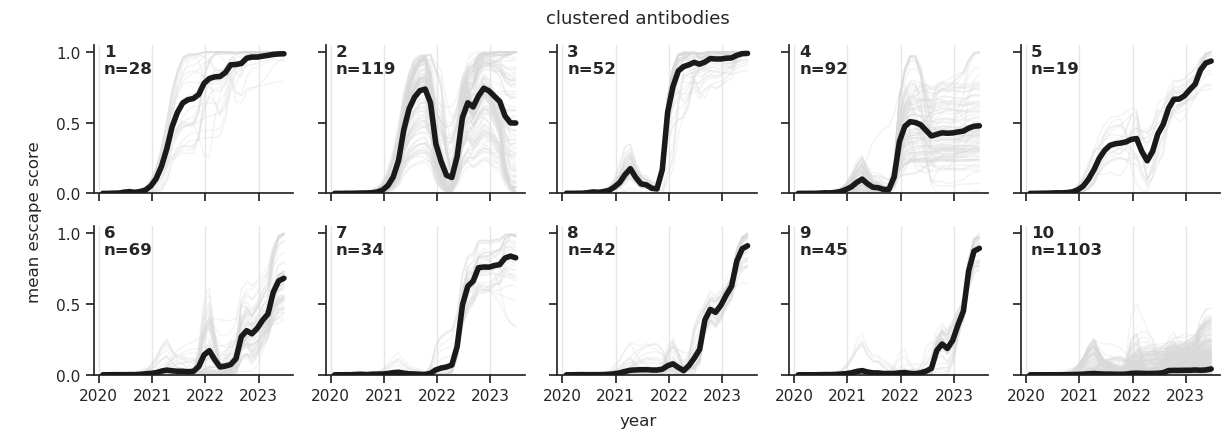

In [16]:
# Plot each antibody group's time series in its own facet
cluster_to_plot = 'escape_cluster' # 'epitope_cluster' # 
data = (
    traj_df[traj_df['epitope_cluster'] != 'other']
    .groupby([cluster_to_plot, 'year']).mean(numeric_only=True)
    .reset_index()
)
data.sort_values(cluster_to_plot, inplace=True)
g = sns.relplot(
    data=data,
    x="year", y="mean_escape", col=cluster_to_plot,
    kind="line", color='k', # hue=cluster_to_plot, palette="crest", 
    linewidth=4, zorder=5,
    col_wrap=5, height=2, aspect=1.2,
    legend=False,
)

# Then plot other antibodies from group or other antibody groups in the background
groupby_cols = [
    'antibody',
    cluster_to_plot,
    'year'
]
for group, ax in g.axes_dict.items():
    data = traj_df[
        ~(traj_df['antibody'].str.contains('Starr')) &
        ~(traj_df['antibody'].str.contains('Dong')) &
        (traj_df[cluster_to_plot] == group)
    ].groupby(groupby_cols).mean(numeric_only=True).reset_index()
    sns.lineplot(
        data=data, x="year", y="mean_escape", units=groupby_cols[0],
        estimator=None, color=".85", linewidth=1, ax=ax, alpha=0.3
    )
    
    n_abs = data['antibody'].nunique()
    ax.text(.05, .81, f'{group}\nn={n_abs}', transform=ax.transAxes, fontweight="bold")
    ax.set(xticks=[2020, 2021, 2022, 2023], yticks=[0,0.5,1], ylim=[0,1.05])
    ax.grid(axis='x', color='0.9')

# Tweak the supporting aspects of the plot
g.set_titles("")
g.set_axis_labels("", "")
g.fig.text(0.5, -0.01, 'year', ha='center')
g.fig.text(-0.01, 0.5, '\nmean escape score', va='center', ha='center', rotation='vertical')
g.tight_layout()
plt.suptitle('clustered antibodies', y=1.03, fontsize=13)
# plt.savefig(f'../results/figures/trajectories_of_{cluster_to_plot}.png', dpi=300, bbox_inches='tight')
plt.show()

Make a list of sites that appear to drive escape in each cluster based on the above analyses. Then, for each cluster, plot the change in frequency of mutations at those sites over time.

/tmp/ipykernel_6145/2139005390.py:70: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(


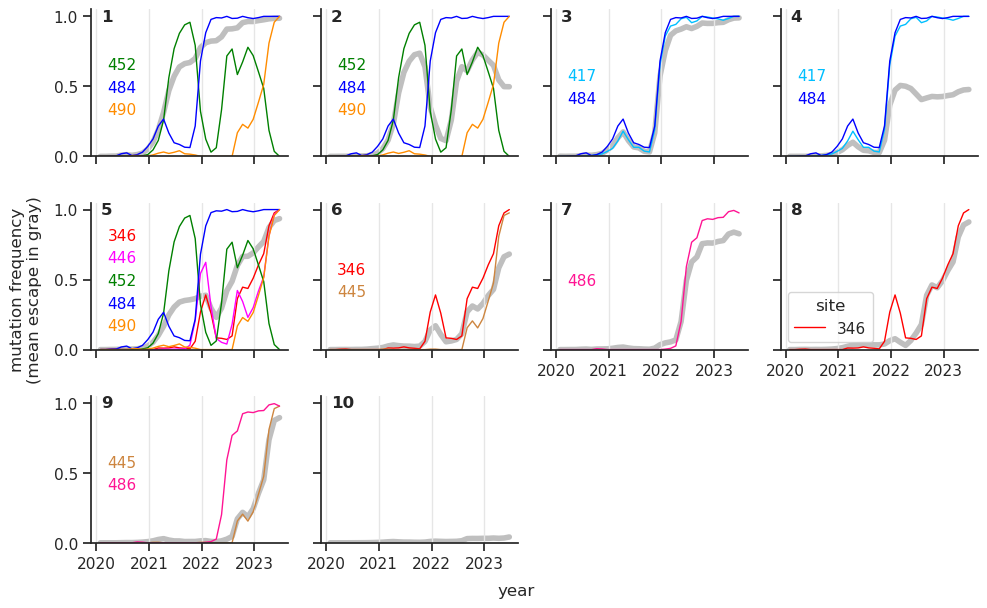

In [17]:
# Identify key sites of escape
key_sites_per_cluster = {}
for cluster in range(1,11):
    data = (
        site_escape_df
        .merge(mut_freq_df.groupby('site', as_index=False)['mut_freq'].max(), on='site', how='inner')
        .query("escape_cluster == @cluster")
    )
    nabs = data['antibody'].nunique()
    data = data[
        (data['normalized_escape'] > 0.4) &
        (data['mut_freq'] > 0.9)
    ]
    site_counts = data['site'].value_counts()
    site_counts = site_counts[site_counts > nabs/4]
    key_sites = list(site_counts.index.values)
    key_sites_per_cluster[cluster] = key_sites

# Plot each antibody group's time series in its own facet
cluster_to_plot = 'escape_cluster'
mut_palette = {
    452 : 'green',
    484 : 'blue',
    490 : 'darkorange',
    417 : 'deepskyblue',
    376 : 'firebrick',
    405 : 'brown',
    408 : 'maroon',    
    346 : 'red',
    446 : 'magenta',
    445 : 'peru',
    486 : 'deeppink',
}
data = (
    traj_df[
        ~(traj_df['antibody'].str.contains('Starr')) &
        ~(traj_df['antibody'].str.contains('Dong'))
    ]
    .groupby([cluster_to_plot, 'year']).mean(numeric_only=True).reset_index()
)
data.sort_values(cluster_to_plot, inplace=True)
g = sns.relplot(
    data=data,
    x="year", y="mean_escape", col=cluster_to_plot,
    kind="line", color='0.75', #palette="crest", # 'husl', 
    linewidth=4, zorder=0,
    col_wrap=4, height=2, aspect=1.2,
    legend=False,
)

# Then plot mutation frequencies
groupby_cols = [
    cluster_to_plot,
    'time'
]
for (group, ax) in g.axes_dict.items():
    data = mut_freq_df[mut_freq_df['site'].isin(key_sites_per_cluster[group])]
    if len(data) > 0:
        g_i = sns.lineplot(
            data=data, x="year", y="mut_freq", units='site',
            estimator=None, linewidth=1, ax=ax, palette=mut_palette,
            hue='site'
        )    
    ax.set(xticks=[2020, 2021, 2022, 2023], yticks=[0,0.5,1], ylim=[0,1.05])
    ax.text(.05, .92, group, transform=ax.transAxes, fontweight="bold")
    ax.grid(axis='x', color='0.9')
    if group == 8:
        continue
    g_i.legend_.set_title(None)
    ax.legend(
        frameon=False, handlelength=0, labelcolor='linecolor',
        loc='center left', bbox_to_anchor=(-0.05,0.47)
    )

# Tweak the supporting aspects of the plot
g.set_titles("")
g.set_axis_labels("", "")
g.fig.text(0.5, -0.01, 'year', ha='center')
g.fig.text(-0.01, 0.5, 'mutation frequency\n(mean escape in gray)', va='center', ha='center', rotation='vertical')
g.tight_layout()
# plt.savefig(f'../results/figures/mut_freq_by_cluster.png', dpi=300, bbox_inches='tight')
plt.show()

Plot the composition of epitopes in each escape cluster.

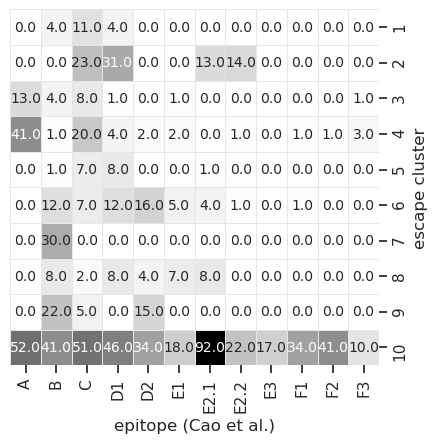

In [18]:
# Get a matrix with the number of antibodies in epitope clusters from Cao et al. vs.
# escape clusters computed here
neut_abs = init_ic50s_df[init_ic50s_df['log_IC50'] < 0]['antibody']
data = (
    # traj_df[
    #     (traj_df['antibody'].isin(neut_abs)) &
    #     ~(traj_df['antibody'].str.contains('Starr')) &
    #     ~(traj_df['antibody'].str.contains('Dong'))
    # ]
    # .drop_duplicates(subset='antibody')
    init_ic50s_df[init_ic50s_df['log_IC50'] < 0]
    .groupby(['epitope_cluster', 'escape_cluster'], as_index=False)['antibody'].count()
    .pivot_table(
        index='epitope_cluster', columns='escape_cluster',
        values='antibody'
    )
    .fillna(0)
    #.apply(lambda col: 100 * col/col.sum())
).T

# Plot the data
cmap = matplotlib.colors.LinearSegmentedColormap.from_list("mycmap", ["white", "black"])
cg = sns.clustermap(
    data, annot=True, fmt=".1f",
    row_cluster=False, col_cluster=False, cmap=cmap,
    figsize=(5.5,5.5), annot_kws={"size": 10}, linewidths=0.5, linecolor='0.9'
)
cg.ax_row_dendrogram.set_visible(False)
cg.ax_col_dendrogram.set_visible(False)
cg.cax.set_visible(False)
ax = cg.ax_heatmap
ax.set(
    xlabel='epitope (Cao et al.)', ylabel='escape cluster'
)
#ax.set_title('percent composition by row', y=1.02)
plt.show()

For each prominent epitope in each cluster, plot average site-level escape scores at sites of strong escape

26


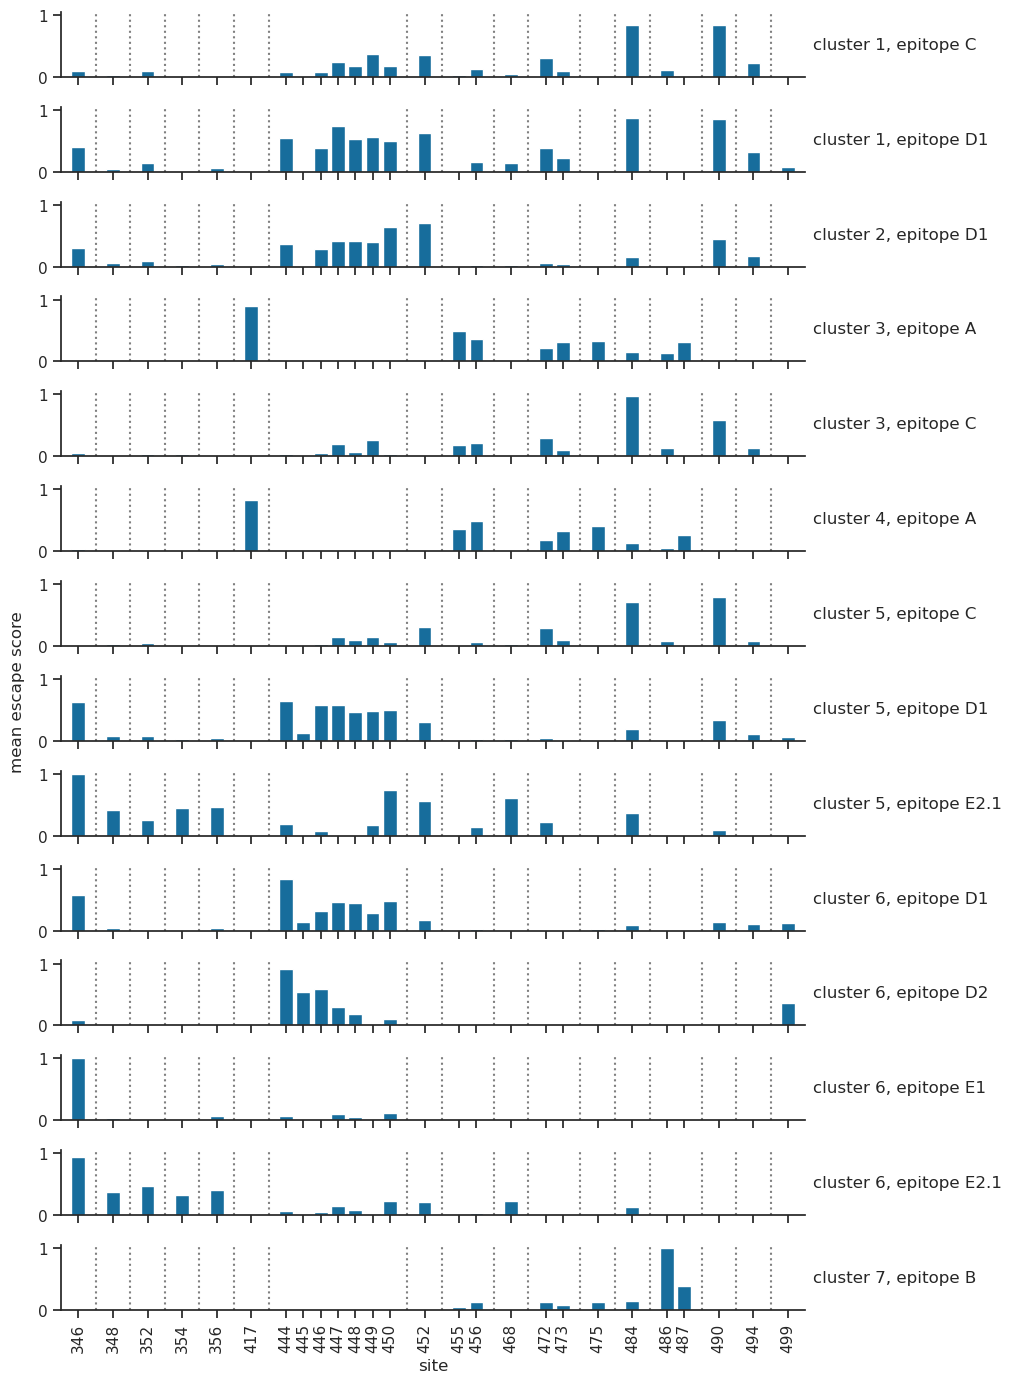

In [19]:
# Get data to plot
groups_to_plot = [
    (1, 'C'),
    (1, 'D1'),

    (2, 'D1'),
    
    (3, 'A'),
    (3, 'C'),

    (4, 'A'),

    (5, 'C'),
    (5, 'D1'),
    (5, 'E2.1'),

    (6, 'D1'),
    (6, 'D2'),
    (6, 'E1'),
    (6, 'E2.1'),

    (7, 'B'),

    # (8, 'A'),
    # (8, 'D1'),
    # (8, 'E2.1'),
    # (8, 'F1'),
    # (8, 'F2'),
]

data_to_plot = (
    ic50s_df
    .drop_duplicates('antibody')[['antibody', 'escape_cluster', 'epitope_cluster']]
    #.query("epitope_cluster == 'D1'")
    .merge(site_escape_df[['antibody', 'site', 'normalized_escape']], on='antibody')
)
data_to_plot['group'] = data_to_plot.apply(lambda row: (row['escape_cluster'], row['epitope_cluster']), axis=1)
data_to_plot = data_to_plot[data_to_plot['group'].isin(groups_to_plot)]

# Add entries of zero for missing sites
null_dict = defaultdict(list)
for site in data_to_plot['site'].unique():
    null_dict['site'].append(site)
    null_dict['normalized_escape'].append(0.0)
null_df = pd.DataFrame(null_dict)
dfs = []
for ((group, ab), ab_data) in data_to_plot.groupby(['group', 'antibody']):
    null_data = null_df.copy()
    null_data['group'] = [group] * len(null_data)
    null_data['antibody'] = ab
    ab_data = (
        pd.concat([null_data, ab_data])
        .groupby(['group', 'antibody', 'site'], as_index=False)['normalized_escape'].sum()
    )
    dfs.append(ab_data)
data_to_plot = pd.concat(dfs)

# Average scores across all antibodies in a group
data_to_plot = (
    data_to_plot
    .groupby(['group', 'site'], as_index=False)
    .agg(mean_normalized_escape = ('normalized_escape', 'mean'))
    .assign(group_title = lambda x: x['group'].map(lambda y: f'cluster {y[0]}, epitope {y[1]}'))
)

# Identify which sites to plot and subset data to only include those sites
sites_to_plot = list(data_to_plot[data_to_plot['mean_normalized_escape'] > 0.3]['site'].unique())
print(len(sites_to_plot))
data_to_plot = data_to_plot[
    (data_to_plot['site'].isin(sites_to_plot))
]

# Make a list of ticks to plot
ticks_to_sites = defaultdict(list)
ticks_to_plot = []
extra_ticks = []
tick = 0
last_site = -100
for (i, site) in enumerate(data_to_plot['site'].unique()):
    if (site -1 != last_site) and (i != 0):
        extra_ticks.append(tick)
        ticks_to_sites['site'].append(-1)
        ticks_to_sites['tick'].append(tick)
        tick += 1
    ticks_to_plot.append(tick)
    ticks_to_sites['site'].append(site)
    ticks_to_sites['tick'].append(tick)
    last_site = site
    tick += 1

ticks_to_sites = pd.DataFrame(ticks_to_sites)

# Plot data
ngroups = data_to_plot['group'].nunique()
(fig, axs) = plt.subplots(
    nrows=ngroups, sharex=True, sharey=True,
    figsize=[10,ngroups]
)

for (i, (group_title, data)) in enumerate(data_to_plot.groupby('group_title')):
    data = (
        data
        .merge(
            ticks_to_sites.assign(group_title = group_title),
            how='outer'
        )
        .fillna(0)
    )
    sns.barplot(x='tick', y='mean_normalized_escape', data=data, ax=axs[i])
    for tick in extra_ticks:
        axs[i].axvline(tick, ls='dotted', c='0.5')
    #axs[i].annotate(group_title, xy=(0.8, .975), transform=ax.transAxes)
    axs[i].text(1.01, 0.5, group_title, horizontalalignment='left', verticalalignment='center', transform=axs[i].transAxes)
    axs[i].set(ylabel='', xlim=[-1,ticks_to_plot[-1]+1])
    axs[i].set_xticks(ticks_to_plot)
    axs[i].set_xticklabels(data[data['site'] > 0]['site'].unique(), rotation=90)

plt.tight_layout()
axs[i].set(xlabel='site')
fig.text(-0.01, 0.5, 'mean escape score', va='center', rotation='vertical')
sns.despine()
# plt.savefig(f'../results/figures/dms_profiles_by_group.png', dpi=300, bbox_inches='tight')
plt.show()

Observations:
* cluster 8, epitope A: similar profile to cluster 3 and 4, but 417 weaker; max mean escape per site not as high
* cluster 8, epitope E2.1: similar profile to cluster 5 and 6, but 346 and 452 weaker
* similar pattern for D1

For a given set of clusters (either epitope or escape), plot the number of antibodies in per cluster and the distribution of their IC50s.

Showing data for 1603 antibodies from the following sources: ['WT convalescents', 'WT vaccinees', 'BA.1 convalescents', 'BA.2 convalescents', 'BA.5 convalescents']


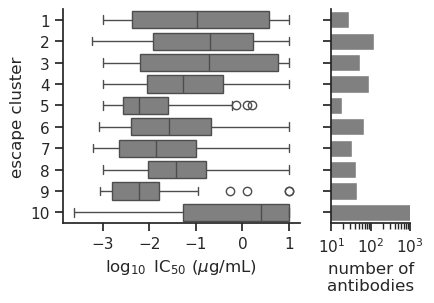

In [20]:
# Get input data
sources = [
    'WT convalescents', 'WT vaccinees',
    'BA.1 convalescents', 
    'BA.2 convalescents', 'BA.5 convalescents',
]
data = init_ic50s_df[init_ic50s_df['source'].isin(sources)].copy()
print(f'Showing data for {len(data)} antibodies from the following sources:', sources)

# Plot the data
cluster_col = 'escape_cluster' # 'epitope_cluster' # 
ic50_metric = 'log_IC50' # 'IC50_weight' # 
data.sort_values(cluster_col, inplace=True)
(fig, axs) = plt.subplots(
    ncols=2, figsize=[4.5,3.2], # [4.5,4], # 
    sharey=True,
    gridspec_kw={'width_ratios': [3, 1]}
)
sns.boxplot(
    x=ic50_metric, y=cluster_col, data=data,
    orient='h', color='0.5', #hue=cluster_col, palette='crest',
    legend=False, ax=axs[0]
)
# sns.pointplot(
#     x=ic50_metric, y=cluster_col, data=data,
#     orient='h', ax=axs[0],
#     estimator=np.median, errorbar=None, linestyle='none',
#     markers="o", color='w', markersize=5, 
# )
ylabel = cluster_col.replace('_', ' ')
if cluster_col == 'epitope_cluster':
    ylabel = 'epitope (Cao et al.)'
axs[0].set(
    ylabel=ylabel, xlabel=r'$\log_{10}$ IC$_{50}$ ($\mu$g/mL)',
    xticks=[-3, -2, -1, 0, 1]
)
sns.countplot(
    y=cluster_col, data=data,
    color='0.5', #hue=cluster_col, palette='crest',
    legend=False, ax=axs[1]
)
axs[1].set(
    xlabel='number of\nantibodies', ylabel='',
    xscale='log', xlim=[10,1000]
)
plt.tight_layout()
sns.despine()
# plt.savefig(f'../results/figures/antibody_stats_{cluster_col}.png', dpi=300, bbox_inches='tight')
plt.show()

Make a heatmap showing how many antibodies from a given epitope cluster fall in a given escape cluster.

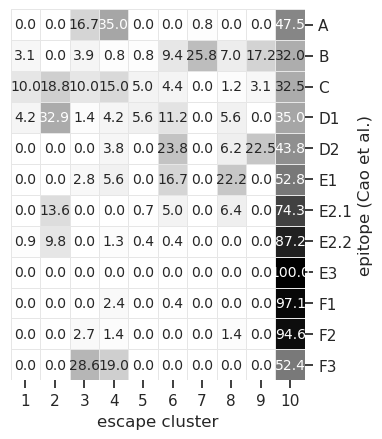

In [21]:
# Get a matrix with the number of antibodies in epitope clusters from Cao et al. vs.
# escape clusters computed here
data = (
    traj_df[
        ~(traj_df['antibody'].str.contains('Starr')) &
        ~(traj_df['antibody'].str.contains('Dong'))
    ]
    .drop_duplicates(subset='antibody')
    .groupby(['epitope_cluster', 'escape_cluster'], as_index=False)['antibody'].count()
    .pivot_table(
        index='escape_cluster', columns='epitope_cluster',
        values='antibody'
    )
    .fillna(0)
    .apply(lambda col: 100 * col/col.sum())
).T

# Plot the data
cmap = matplotlib.colors.LinearSegmentedColormap.from_list("mycmap", ["white", "black"])
cg = sns.clustermap(
    data, annot=True, fmt=".1f",
    row_cluster=False, col_cluster=False, cmap=cmap,
    figsize=(4.75,5.5), annot_kws={"size": 10}, linewidths=0.5, linecolor='0.9'
)
cg.ax_row_dendrogram.set_visible(False)
cg.ax_col_dendrogram.set_visible(False)
cg.cax.set_visible(False)
ax = cg.ax_heatmap
ax.set(
    xlabel='escape cluster', ylabel='epitope (Cao et al.)'
)
# plt.savefig(f'../results/figures/escape_cluster_epitope_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

Make a heatmap showing the fraction of neutralizing antibodies from a given source fall in a given escape cluster

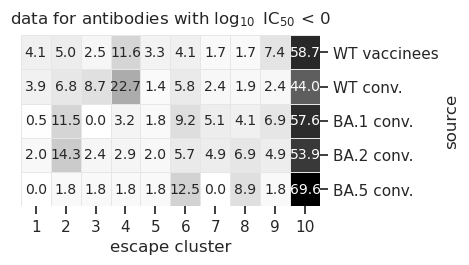

In [22]:
sources = [
    'WT vaccinees', 'WT convalescents',
    'BA.1 convalescents', 
    'BA.2 convalescents', 'BA.5 convalescents',
]

neut_abs = init_ic50s_df[init_ic50s_df['log_IC50'] < 0]['antibody']
data = (
    ic50s_df[ic50s_df['antibody'].isin(neut_abs)]
    .drop_duplicates(subset='antibody')
    .groupby(['source', 'escape_cluster'], as_index=False)['antibody'].count()
    .pivot_table(
        index='escape_cluster', columns='source',
        values='antibody'
    )
    .fillna(0)
    .apply(lambda col: 100 * col/col.sum())
    .rename(columns={col : col.replace('convalescents', 'conv.') for col in sources})
).T

# Plot the data
sources = [col.replace('convalescents', 'conv.') for col in sources]
cmap = matplotlib.colors.LinearSegmentedColormap.from_list("mycmap", ["white", "black"])
cg = sns.clustermap(
    data.loc[sources], annot=True, fmt=".1f",
    row_cluster=False, col_cluster=False, cmap=cmap,
    figsize=(5.5,3), annot_kws={"size": 10}, linewidths=0.5, linecolor='0.9'
)
cg.ax_row_dendrogram.set_visible(False)
cg.ax_col_dendrogram.set_visible(False)
cg.cax.set_visible(False)
ax = cg.ax_heatmap
ax.set(xlabel='escape cluster', ylabel='source')
ax.set_title('data for antibodies with $\log_{10}$ IC$_{50}$ < 0', y=1.02)
# plt.savefig(f'../results/figures/escape_cluster_source_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

## Validate predictions using IC50 data

What is the correlation in IC50s between different experiments?

0.87 0.0


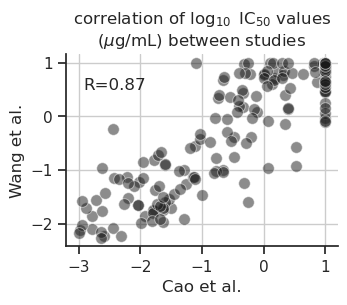

In [23]:
viruses = ['D614G', 'BA.1']
data = (
    ic50s_df[ic50s_df['virus'].isin(viruses)]
    .pivot_table(index=['antibody', 'virus'], columns='study', values='log_IC50')
    .dropna(subset=['Cao et al.', 'Wang et al. pv'])
)

(r, p) = scipy.stats.pearsonr(data['Cao et al.'], data['Wang et al. pv'])
print(round(r, 2), round(p, 2))

# Plot data
plt.figure(figsize=[3.5,2.5])
sns.scatterplot(x='Cao et al.', y='Wang et al. pv', data=data, s=70, alpha=0.5, c='k')
plt.annotate(f'R={round(r,2)}', [-2.92, 0.5])
plt.ylabel('Wang et al.')
plt.title('correlation of $\log_{10}$ IC$_{50}$ values\n($\mu$g/mL) between studies')
plt.grid()
sns.despine()
# plt.savefig(f'../results/figures/validation_study_corr.png', dpi=300, bbox_inches='tight')
plt.show()

Identify viral sequences that match specific variants of concern with experimental IC50 data, then merge their predicted escape scores for each antibody with the dataframe with IC50 data for those same variants and antibodies.

In [24]:
# Make a list of mutations in each strain in the alignmnet relative to WH1
strain_muts_df = escape_scores_df.drop_duplicates('strain').copy()
strain_muts_df['all_aa_substitutions'] = strain_muts_df['all_aa_substitutions'].fillna('')
strain_muts_df['mutations'] = strain_muts_df['all_aa_substitutions'].apply(
    lambda x: set(x.split(' '))
)

# Get a dictionary giving the mutations in each clade
voc_muts_dict = clusters.clusters

# Map strains from IC50 experiments to clades from above dict
voc_to_clade_dict = {
    'Alpha' : 'Alpha',
    'Beta' : 'Beta',
    'Gamma' : 'Gamma',
    'Delta' : 'Delta',
    'Lambda' : '21GLambda',
    'BA.1' : '21K.Omicron',
    'BA.2' : '21L.Omicron',
    'BA.2.75' : '22D',
    'BA.5' : '22B',
    'BQ.1.1' : '22E', # BQ.1 is the founder for 22E; BQ.1.1 is descendant from BQ.1, but has the R346T mutation
    'XBB' : '22F'
}
voc_to_strain_dict = {
    'D614G' : ('Wuhan-Hu-1/2019', [])
}
voc_n_rbd_muts = defaultdict(list)
voc_n_rbd_muts['virus'].append('D614G')
voc_n_rbd_muts['muts'].append([])
voc_n_rbd_muts['n_muts'].append(0)
muts_to_ignore = ['R493Q', 'Q493Q'] # R493R is a reversion
for (voc, clade) in voc_to_clade_dict.items():
    muts = [
        f"{entry['left']}{entry['pos']}{entry['right']}" for entry in
        voc_muts_dict[clade]['mutations']['nonsynonymous']
        if entry['gene'] == 'S'
    ]
    for mut in muts_to_ignore:
        if mut in muts:
            muts.remove(mut)
    if voc == 'BQ.1.1': # BQ.1 is the founder for 22E; BQ.1.1 is descendant from BQ.1, but has the R346T mutation
        muts.append('R346T')
    print(voc, muts)
    voc_n_rbd_muts['virus'].append(voc)
    voc_n_rbd_muts['muts'].append(muts)
    voc_n_rbd_muts['n_muts'].append(len([mut for mut in muts if (331 <= int(mut[1:-1]) <= 531)]))

    # Get the virus with the fewest differences
    strain_muts_df['diffs'] = strain_muts_df['mutations'].apply(
        lambda x: set.symmetric_difference(x, muts)
    )
    strain_muts_df['ndiffs'] = strain_muts_df['diffs'].apply(lambda x: len(x))
    strain_muts_df.sort_values(['ndiffs', 'strain'], inplace=True)
    virus = strain_muts_df['strain'].iloc[0]
    ndiffs = strain_muts_df['ndiffs'].iloc[0]
    diffs = strain_muts_df['diffs'].iloc[0]
    voc_to_strain_dict[voc] = (virus, muts)
    
    if ndiffs > 0:
        print(virus, ndiffs, diffs, '\n')
        raise ValueError()

voc_n_rbd_muts = pd.DataFrame(voc_n_rbd_muts)

# Get predicted escape scores for each VOC relative to each antibody
dfs = []
for (voc, voc_values) in voc_to_strain_dict.items():
    data = escape_scores_df[escape_scores_df['strain'] == voc_values[0]].copy()
    data['virus'] = voc
    dfs.append(data)
pred_ic50s = pd.concat(dfs)

# Then merge the above predictions with the experimental IC50 data on the same VOC/antibody
# combinations
if 'escape_score' not in ic50s_df:
    ic50s_df = (
        ic50s_df
        .merge(
            pred_ic50s[['virus', 'antibody', 'escape_score']],
            on=['antibody', 'virus'], how='left'
        )
        .merge(voc_n_rbd_muts, how='left')
    )

Alpha ['H69-', 'V70-', 'Y144-', 'N501Y', 'A570D', 'D614G', 'P681H', 'T716I', 'S982A', 'D1118H']
Beta ['D80A', 'D215G', 'L241-', 'L242-', 'A243-', 'K417N', 'E484K', 'N501Y', 'D614G', 'A701V']
Gamma ['L18F', 'T20N', 'P26S', 'D138Y', 'R190S', 'K417T', 'E484K', 'N501Y', 'D614G', 'H655Y', 'T1027I', 'V1176F']
Delta ['T19R', 'G142D', 'E156-', 'F157-', 'R158G', 'L452R', 'T478K', 'D614G', 'P681R', 'D950N']
Lambda ['G75V', 'T76I', 'R246-', 'S247-', 'Y248-', 'L249-', 'T250-', 'P251-', 'G252-', 'D253N', 'L452Q', 'F490S', 'D614G', 'T859N']
BA.1 ['A67V', 'H69-', 'V70-', 'T95I', 'G142-', 'V143-', 'Y144-', 'Y145D', 'N211-', 'L212I', 'G339D', 'S371L', 'S373P', 'S375F', 'K417N', 'N440K', 'G446S', 'S477N', 'T478K', 'E484A', 'Q493R', 'G496S', 'Q498R', 'N501Y', 'Y505H', 'T547K', 'D614G', 'H655Y', 'N679K', 'P681H', 'N764K', 'D796Y', 'N856K', 'Q954H', 'N969K', 'L981F']
BA.2 ['T19I', 'L24-', 'P25-', 'P26-', 'A27S', 'G142D', 'V213G', 'G339D', 'S371F', 'S373P', 'S375F', 'T376A', 'D405N', 'R408S', 'K417N', 'N440

Examine RBD mutations in each of the above variants and compare strains to make sure mutation differences match those reported by [Cao et al.](https://www.nature.com/articles/s41586-022-05644-7#Sec8). Supplementary Table 3 reports RBD mutations in BA.2.75, BQ.1.1, and XBB relative to BA.2 and BA.5. The reported mutations match the ones from above. Though the table does not give BA.1, BA.2, or BA.5 sequences. The Methods section on estimating preferences defines BA.5 RBD mutations relative to BA.2, and it matches the ones from above. An earlier [Cao et al.](https://www.nature.com/articles/s41586-022-04980-y) study with overlap in neutralizationd ata reports mutations in BA.1 and BA.2 variants. They match the mutations from above, except that BA.2 is reported as having the G446S mutation. This seems to be an error, as Supplementary Table 3 from above reports some variants as having G446S mutations relative to the BA.2 variant.

In [25]:
rbd_muts_dict = {}
for (i, row) in voc_n_rbd_muts.iterrows():
    rbd_muts = set([mut for mut in row['muts'] if 331 <= int(mut[1:-1]) <= 551])
    rbd_muts_dict[row['virus']] = rbd_muts
    print(row['virus'], rbd_muts)

D614G set()
Alpha {'N501Y'}
Beta {'N501Y', 'K417N', 'E484K'}
Gamma {'N501Y', 'E484K', 'K417T'}
Delta {'L452R', 'T478K'}
Lambda {'F490S', 'L452Q'}
BA.1 {'S373P', 'Q493R', 'N440K', 'G339D', 'Q498R', 'G446S', 'E484A', 'T478K', 'G496S', 'N501Y', 'S375F', 'T547K', 'S477N', 'K417N', 'Y505H', 'S371L'}
BA.2 {'S373P', 'S371F', 'Q493R', 'N440K', 'G339D', 'T376A', 'Q498R', 'D405N', 'E484A', 'T478K', 'N501Y', 'S375F', 'S477N', 'K417N', 'R408S', 'Y505H'}
BA.2.75 {'S373P', 'S371F', 'N440K', 'T376A', 'Q498R', 'D405N', 'G446S', 'E484A', 'T478K', 'N501Y', 'S375F', 'R408S', 'S477N', 'K417N', 'G339H', 'Y505H', 'N460K'}
BA.5 {'S373P', 'S371F', 'N440K', 'G339D', 'T376A', 'Q498R', 'D405N', 'E484A', 'T478K', 'N501Y', 'S375F', 'F486V', 'S477N', 'L452R', 'K417N', 'R408S', 'Y505H'}
BQ.1.1 {'S373P', 'T376A', 'E484A', 'R346T', 'F486V', 'Y505H', 'N460K', 'S371F', 'G339D', 'Q498R', 'T478K', 'S375F', 'S477N', 'L452R', 'N440K', 'N501Y', 'K444T', 'D405N', 'K417N', 'R408S'}
XBB {'S373P', 'L368I', 'T376A', 'R346T', 'E48

In [26]:
ref_strain = 'BA.2'
derived_strain = 'BA.2.75'
print(f'muts in {derived_strain} not in {ref_strain}:')
print(rbd_muts_dict[derived_strain].difference(rbd_muts_dict[ref_strain]))
print(f'muts in {ref_strain} not in {derived_strain}:')
print(rbd_muts_dict[ref_strain].difference(rbd_muts_dict[derived_strain]))

muts in BA.2.75 not in BA.2:
{'G339H', 'G446S', 'N460K'}
muts in BA.2 not in BA.2.75:
{'Q493R', 'G339D'}


In [27]:
ref_strain = 'BA.2'
derived_strain = 'BA.5'
print(f'muts in {derived_strain} not in {ref_strain}:')
print(rbd_muts_dict[derived_strain].difference(rbd_muts_dict[ref_strain]))
print(f'muts in {ref_strain} not in {derived_strain}:')
print(rbd_muts_dict[ref_strain].difference(rbd_muts_dict[derived_strain]))

muts in BA.5 not in BA.2:
{'L452R', 'F486V'}
muts in BA.2 not in BA.5:
{'Q493R'}


In [28]:
ref_strain = 'BA.5'
derived_strain = 'BQ.1.1'
print(f'muts in {derived_strain} not in {ref_strain}:')
print(rbd_muts_dict[derived_strain].difference(rbd_muts_dict[ref_strain]))
print(f'muts in {ref_strain} not in {derived_strain}:')
print(rbd_muts_dict[ref_strain].difference(rbd_muts_dict[derived_strain]))

muts in BQ.1.1 not in BA.5:
{'K444T', 'R346T', 'N460K'}
muts in BA.5 not in BQ.1.1:
set()


In [29]:
ref_strain = 'BA.2'
derived_strain = 'XBB'
print(f'muts in {derived_strain} not in {ref_strain}:')
print(rbd_muts_dict[derived_strain].difference(rbd_muts_dict[ref_strain]))
print(f'muts in {ref_strain} not in {derived_strain}:')
print(rbd_muts_dict[ref_strain].difference(rbd_muts_dict[derived_strain]))

muts in XBB not in BA.2:
{'L368I', 'V445P', 'R346T', 'G446S', 'F486S', 'G339H', 'F490S', 'N460K'}
muts in BA.2 not in XBB:
{'Q493R', 'G339D'}


In [30]:
ref_strain = 'BA.1'
derived_strain = 'BA.2'
print(f'muts in {derived_strain} not in {ref_strain}:')
print(rbd_muts_dict[derived_strain].difference(rbd_muts_dict[ref_strain]))
print(f'muts in {ref_strain} not in {derived_strain}:')
print(rbd_muts_dict[ref_strain].difference(rbd_muts_dict[derived_strain]))

muts in BA.2 not in BA.1:
{'T376A', 'R408S', 'S371F', 'D405N'}
muts in BA.1 not in BA.2:
{'T547K', 'G446S', 'G496S', 'S371L'}


Do experimentally IC50 values support the predicted escape scores?

In [31]:
# Plotting params
virus_order = [
    'D614G',
    'Alpha', 'Beta', 'Gamma',
    'Lambda', 'Delta', 
    'Omicron',
    'BA.1', 'BA.2', 'BA.2.75',
    'BA.5', 'BQ.1.1',
    'XBB', 'XBB.1.5'
]
studies = [
    'Wang et al. pv',
    #'Wang et al. av',
    'Cao et al.',
]

for (study, data) in ic50s_df.groupby('study'):

    # Select antibodies with a logIC50 below zero for D614G
    pivoted_data = data.pivot(
        index='antibody', columns='virus', values='log_IC50'
    )
    antibodies_to_plot = list(set(pivoted_data[
        (pivoted_data['D614G'] <= 0)
    ].index.values))
    print(study, len(pivoted_data), len(antibodies_to_plot))

Cao et al. 1603 846
Wang et al. av 90 68
Wang et al. pv 90 66


In [38]:
with open('../results/abs_with_large_diffs_Cao.txt') as f:
    abs_with_large_diffs_Cao = [line.strip() for line in f.readlines()]
print(len(abs_with_large_diffs_Cao))

with open('../results/abs_with_large_diffs_Wang.txt') as f:
    abs_with_large_diffs_Wang = [line.strip() for line in f.readlines()]
print(len(abs_with_large_diffs_Wang))

81
16


1


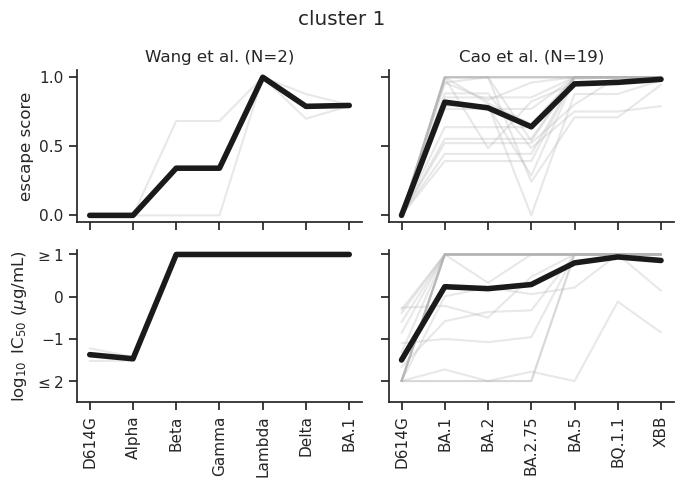

2


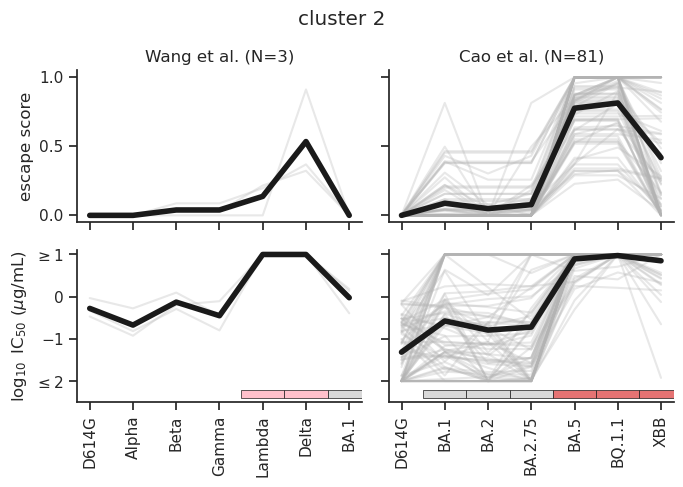

3


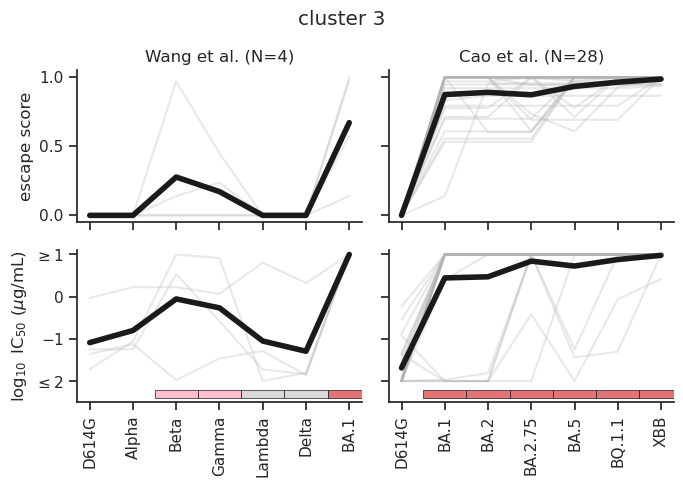

4


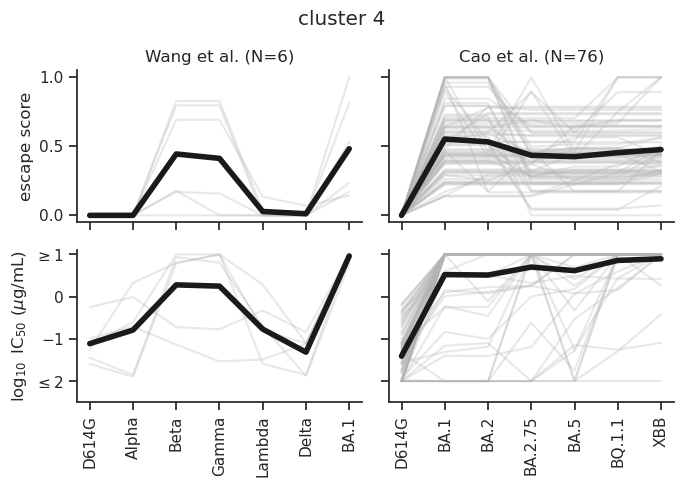

5


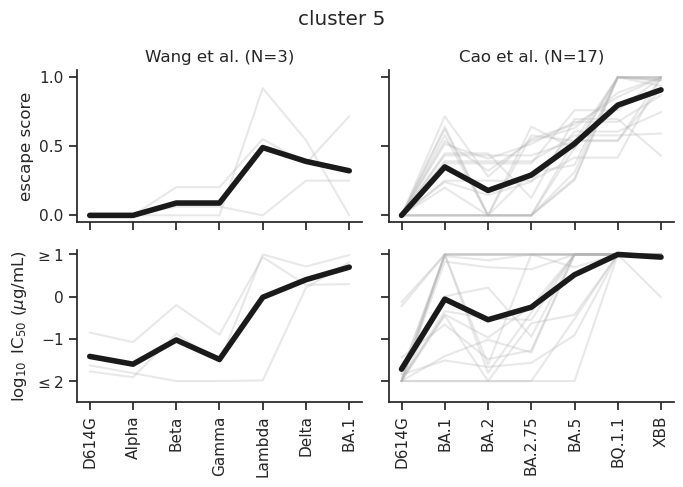

6
1 122
58 122


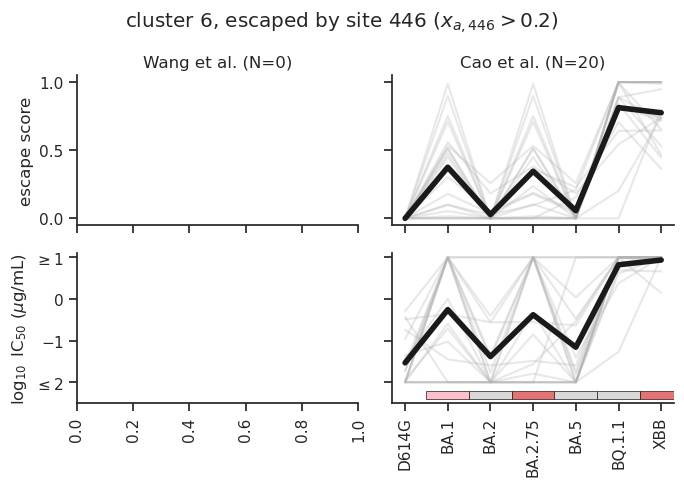

7
Skipping 7 Wang et al. pv


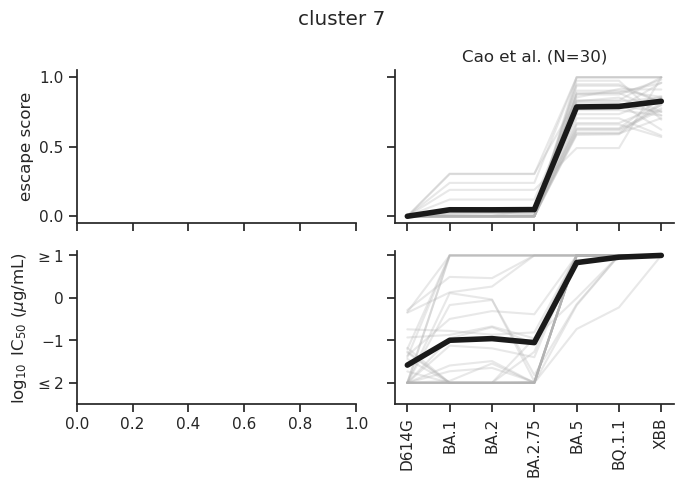

8


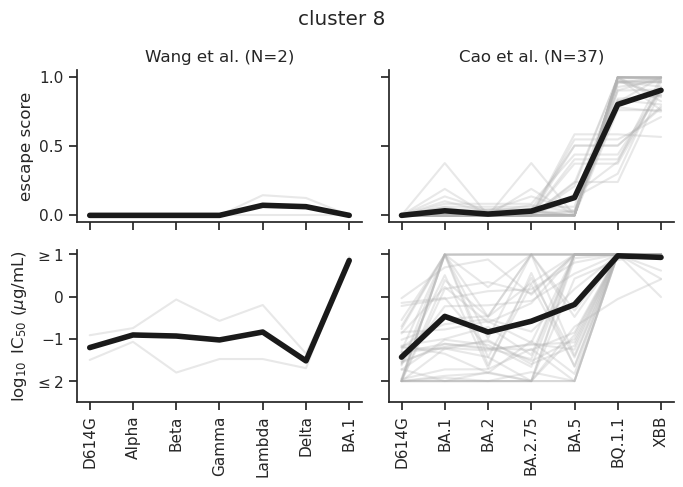

9


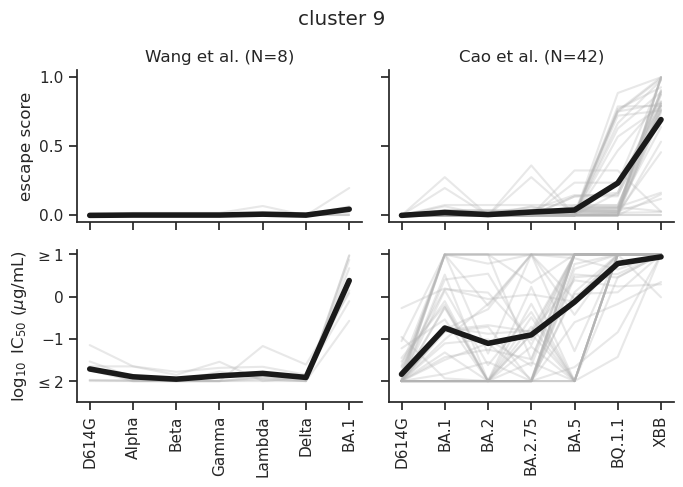

10


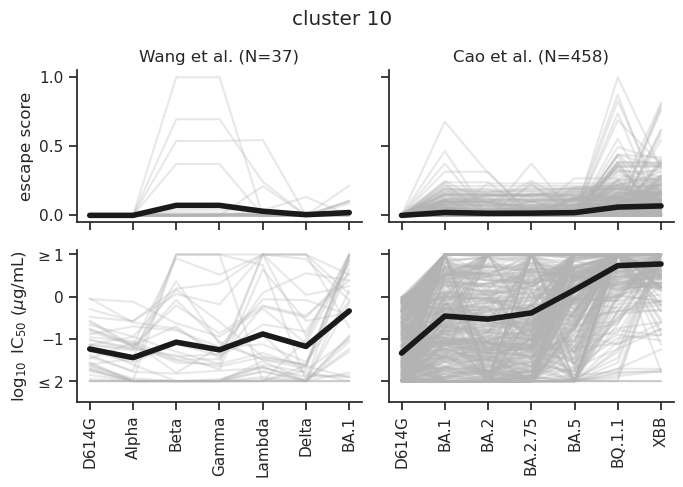

In [44]:
# Plotting params
virus_order = [
    'D614G',
    'Alpha', 'Beta', 'Gamma',
    'Lambda', 'Delta', 
    'Omicron',
    'BA.1', 'BA.2', 'BA.2.75',
    'BA.5', 'BQ.1.1',
    'XBB', 'XBB.1.5'
]
studies = [
    'Wang et al. pv',
    'Cao et al.',
]
study_pal = {
    'Wang et al. pv' : '#0173b2',
    'Cao et al.' : 'firebrick'
}

clusters_to_plot = list(range(1, 11))
plot_cluster_6_446_subset = True
ic50_corr_dict = defaultdict(list)
ab_corr_dict = defaultdict(list)

for cluster in clusters_to_plot:

    print(cluster)
    (fig, axs) = plt.subplots(
        ncols=2, nrows=2, figsize=[7,5], sharex='col', sharey='row',
        gridspec_kw={'width_ratios': [1, 1]}
    )
    axs = axs.reshape(-1)

    for (ax_i, study) in enumerate(studies):
        
        # Get IC50 data
        data = ic50s_df[
            (ic50s_df['escape_cluster'] == cluster) &
            (ic50s_df['virus'].isin(virus_order)) &
            (ic50s_df['study'] == study)
        ].copy()
        if len(data) == 0:
            print('Skipping', cluster, study)
            continue
        data['clipped_log_IC50'] = data['log_IC50'].clip(lower=-2)
        data['clipped_delta_log_IC50'] = data['delta_log_IC50'].clip(lower=0, upper=3)

        # Sort the viruses for the x-axis
        virus_index_dict = {
            virus : i
            for (i, virus) in enumerate(virus_order)
        }
        data['order'] = data['virus'].apply(lambda x: virus_index_dict[x])
        data.sort_values('order', inplace=True)
        hue_order = sorted(data['antibody'].unique())
        
        # Select antibodies with a logIC50 below zero for D614G
        pivoted_data = data.pivot(
            index='antibody', columns='virus', values='log_IC50'
        )
        antibodies_to_plot = set(pivoted_data[
            (pivoted_data['D614G'] <= 0)
        ].index.values)
        #antibodies_to_plot = [ab for ab in antibodies_to_plot if ab in list(abs_with_large_diffs_Cao)]
        if len(antibodies_to_plot) == 0:
            continue

        data = data[data['antibody'].isin(antibodies_to_plot)]

        # Compute the correlation between escape scores and IC50s, or number
        # of mutations in a variant and IC50s
        IC50_metric = 'log_IC50'
        ab_rs = []
        for (antibody, ab_data) in data.groupby('antibody'):
            r = ab_data['escape_score'].corr(ab_data[IC50_metric])
            r_n_muts = ab_data['n_muts'].corr(ab_data[IC50_metric])
            ab_corr_dict['cluster'].append(cluster)
            ab_corr_dict['study'].append(study)
            ab_corr_dict['antibody'].append(antibody)
            ab_corr_dict['r'].append(round(r, 2))
            ab_corr_dict['r_n_muts'].append(round(r_n_muts, 2))
            ab_corr_dict['max_escape_score'].append(ab_data['escape_score'].max())


        ################
        # Make line plots
        ################

        pivoted_data = data.pivot(
            index='antibody', columns='virus', values='escape_score' # 'log_IC50' # 
        )

        # For cluster 6, select a subset of antibodies to plot in the line plot
        if cluster == 6:
            subset_site = 446
            antibody_subset = site_escape_df[
                (site_escape_df['site'] == subset_site) &
                (site_escape_df['normalized_escape'] > 0.2)
            ]['antibody'].unique()
            if plot_cluster_6_446_subset:
                data = data[data['antibody'].isin(antibody_subset)]
            else:
                data = data[~data['antibody'].isin(antibody_subset)]
            print(len(antibodies_to_plot), len(antibody_subset))

        # Plot data
        ic50_metric = 'clipped_log_IC50' # 'clipped_delta_log_IC50' # 'delta_log_IC50' # 
        escape_metric = 'escape_score' # 'n_muts' # 
        for metric in [escape_metric, ic50_metric]:
            if metric == escape_metric:
                n_abs = len(data['antibody'].unique())
                axs[ax_i].set(title=f"{study.replace(' pv', '')} (N={n_abs})")
                metric_ax_i = ax_i
            else:
                # axs[ax_i+2].axhline(1, ls='--', lw=0.5, zorder=10)
                # axs[ax_i+2].axhline(-2, ls='--', lw=0.5, zorder=10)
                metric_ax_i = ax_i + 2
            if len(data) == 0:
                continue
            sns.lineplot(
                x='virus', y=metric, data=data, ax=axs[metric_ax_i],
                units='antibody', estimator=None, c='0.7', alpha=0.3
                #hue='antibody', hue_order=hue_order,
            )
            sns.lineplot(
                x='virus', y=metric, data=data, ax=axs[metric_ax_i],
                linewidth=4, estimator='mean', errorbar=None, color='k' # color=study_pal[study],
            )

        for tick in axs[ax_i+2].get_xticklabels():
            tick.set_rotation(90)

    # Add rectangles
    cluster_rec_params = {
        2 : [
            (2, 3.5, 'pink'), (2, 4.5, 'pink'),
            (2, 5.5, '0.85'), (3, 0.5, '0.85'), (3, 1.5, '0.85'), (3, 2.5, '0.85'),
            (3, 3.5, '#E57373'), (3, 4.5, '#E57373'), (3, 5.5, '#E57373'),
        ],
        3 : [
            (2, 1.5, 'pink'), (2, 2.5, 'pink'),
            (2, 3.5, '0.85'), (2, 4.5, '0.85'),
            (2, 5.5, '#E57373'), (3, 0.5, '#E57373'), (3, 1.5, '#E57373'), (3, 2.5, '#E57373'),
            (3, 3.5, '#E57373'), (3, 4.5, '#E57373'), (3, 5.5, '#E57373'),
        ],
        6 : [
            #(2, 1.5, 'pink'), (2, 2.5, 'pink'),
            #(2, 3.5, '0.85'), (2, 4.5, '0.85'),
            (2, 5.5, 'pink'), (3, 0.5, 'pink'),
            (3, 1.5, '0.85'), (3, 2.5, '#E57373'),
            (3, 3.5, '0.85'), (3, 4.5, '0.85'), (3, 5.5, '#E57373'),
        ],
    }
    if cluster in cluster_rec_params:
        if (cluster == 6) and (plot_cluster_6_446_subset == False):
            rec_params = []
        else:
            rec_params = cluster_rec_params[cluster]
        for (ax_i, x, c) in rec_params:
            rect = patches.Rectangle((x, -2.4), 1, 0.2, linewidth=0.5, edgecolor='k', facecolor=c)
            axs[ax_i].add_patch(rect)

    # Tweak plots
    axs[0].set(yticks=[0, 0.5, 1], ylabel='escape score')
    axs[1].set(ylabel='')
    axs[2].set(
        xlabel='', ylim=[-2.5, 1.1], yticks=[-2, -1, 0, 1], ylabel=r'$\log_{10}$ IC$_{50}$ ($\mu$g/mL)'
    )
    axs[2].set_yticklabels(['$\leq2$', '$-1$', '$0$', '$\geq1$'])
    axs[3].set(xlabel='', ylabel='')
    if cluster == 6:
        if plot_cluster_6_446_subset:
            title = 'cluster 6, escaped by site 446 ($x_{a,446}>0.2$)'
        else:
            title = 'cluster 6, not escaped by site 446 ($x_{a,446}\leq0.2$)'
    else:
        title = f'cluster {cluster}'
    plt.suptitle(title, y=0.97)
    plt.tight_layout()
    sns.despine()
    # if cluster == 6:
    #     if plot_cluster_6_446_subset:
    #         # plt.savefig(f'../results/figures/validation_cluster_{cluster}_446.png', dpi=300, bbox_inches='tight')
    #     else:
    #         # plt.savefig(f'../results/figures/validation_cluster_{cluster}_not_446.png', dpi=300, bbox_inches='tight')
    # else:
    #     # plt.savefig(f'../results/figures/validation_cluster_{cluster}.png', dpi=300, bbox_inches='tight')
    plt.show()

ab_corr_df = pd.DataFrame(ab_corr_dict)
ab_corr_df['r'] = ab_corr_df['r'].fillna(0)
ab_corr_df['delta_r'] = ab_corr_df['r_n_muts'] - ab_corr_df['r']
ab_corr_df.to_csv('../results/ab_corr_df_v2.csv', index=False)

In [37]:
# Get list of cluster 6 antibodies
cluster = 6
data = ic50s_df[
    (ic50s_df['study'] == 'Cao et al.') &
    (ic50s_df['escape_cluster'] == cluster)
].copy()
pivoted_data = data.pivot(
    index='antibody', columns='virus', values='log_IC50'
)
antibodies_to_plot = set(pivoted_data[
    (pivoted_data['D614G'] <= 0)
].index.values)

print('N antibodies with data in cluster 6:', len(antibodies_to_plot))

antibody_subset_446 = site_escape_df[
    (site_escape_df['antibody'].isin(antibodies_to_plot)) &
    (site_escape_df['site'] == 446) &
    (site_escape_df['escape_cluster'] == 6) &
    (site_escape_df['normalized_escape'] > 0.2)
]['antibody'].unique()
print('N antibodies escaped by 446:', len(antibody_subset_446))

antibody_subset_346 = site_escape_df[
    (site_escape_df['antibody'].isin(antibodies_to_plot)) &
    (site_escape_df['site'] == 346) &
    (site_escape_df['escape_cluster'] == 6) &
    (site_escape_df['normalized_escape'] > 0.2)
]['antibody'].unique()
print('N antibodies escaped by 346:', len(antibody_subset_346))

print('overlap:', len(set.intersection(set(antibody_subset_446), set(antibody_subset_346))))

N antibodies with data in cluster 6: 58
N antibodies escaped by 446: 20
N antibodies escaped by 346: 24
overlap: 7


Plot correlation coefficients by cluster and study

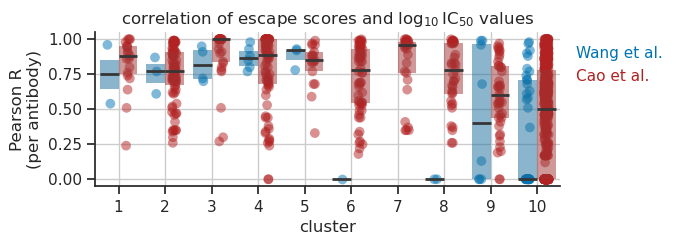

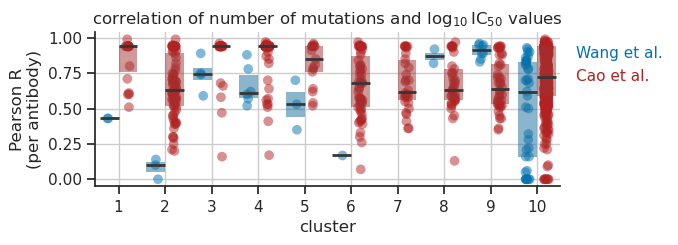

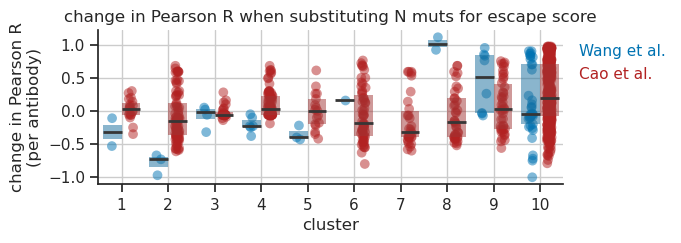

In [38]:
study_pal = {
    'Wang et al.' : '#0173b2',
    'Cao et al.' : 'firebrick'
}
plot_vars = [
    ('escape scores', 'r', 0),
    ('number of mutations', 'r_n_muts', 0),
    ('delta R', 'delta_r', -1),
]
for (title_var, corr_metric, lower_lim) in plot_vars:
    data = ab_corr_df.copy()
    data[corr_metric] = data[corr_metric].clip(lower=lower_lim)
    data['study'] = data['study'].replace('Wang et al. pv', 'Wang et al.')
    plt.figure(figsize=[6,2])
    hue_order = ['Wang et al.', 'Cao et al.']
    sns.stripplot(
        x='cluster', y=corr_metric, data=data,
        hue='study', hue_order=hue_order, palette=study_pal,
        dodge=True, alpha=0.5, s=7
    )
    sns.boxplot(
        x='cluster', y=corr_metric, data=data,
        hue='study', hue_order=hue_order, palette=study_pal,
        legend=False, showfliers=False, whis=0, linewidth=0,
        medianprops={"linewidth": 2}, boxprops={'alpha':.5}, zorder=10,
    )
    ax = plt.gca()
    if corr_metric == 'delta_r':
        ylabel = 'change in Pearson R\n(per antibody)'
        title = 'change in Pearson R when substituting N muts for escape score'
    else:
        ylabel = 'Pearson R\n(per antibody)'
        title = f'correlation of {title_var} and ' + r'$\log_{10}\text{IC}_{50}$ values'
    ax.set(ylabel=ylabel, title=title)
    ax.legend(
        frameon=False, markerscale=0, labelcolor='linecolor',
        loc='upper right', bbox_to_anchor=(1.25,1)
    )
    plt.grid()
    sns.despine()
    # plt.savefig(f'../results/figures/validation_corr_{corr_metric}.png', dpi=300, bbox_inches='tight')
    plt.show()

Notes on antibodies from Bloom lab

* LY-CoV555
    * an example of an antibody where escape is maintained by different mutations? First 484, then 452?
    * IC50 data from 
* LY-CoV016 and REGN10933 examples of an antibody where escape dips with delta (supported by this paper: https://www.nature.com/articles/s41586-021-03777-9; https://www.sciencedirect.com/science/article/pii/S2211124722013845?via%3Dihub)
    * though DMS predictions for REGN10933 are inaccurate for pre-Delta VOCs, so don't see dip
* REGN10987 an example of an antibody where escape at year 2.5?
* other antibodies include examples of escape tracking with a single mutation that increases monotonically until it fixes.


Atlas of IC50s against many different Omicron variants: https://www.sciencedirect.com/science/article/pii/S2666379123000976?via%3Dihub

In [43]:
data = traj_df.groupby('antibody', as_index=False)['mean_escape'].max()
data['method'] = 'aa'
data.to_csv('../results/traj_max_v2.csv', index=False)


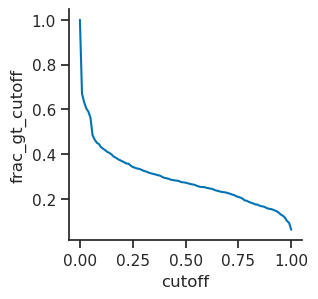

In [39]:
# Compute fraction of trajectories passing a given cutoff
c_dist_dict = defaultdict(list)
data = traj_df.groupby('antibody', as_index=False)['mean_escape'].max()
cutoffs = np.arange(0, 1.01, 0.01)
for cutoff in cutoffs:
    c_dist_dict['cutoff'].append(cutoff)
    c_dist_dict['frac_gt_cutoff'].append(sum(data['mean_escape'] >= cutoff)/len(data))
c_dist_df = pd.DataFrame(c_dist_dict)
c_dist_df.to_csv('../results/c_dist_df_v2.csv', index=False)

# Plot distribution
plt.figure(figsize=[3,3])
sns.lineplot(x='cutoff', y='frac_gt_cutoff', data=c_dist_df)
sns.despine()
plt.show()

## Examine the evolutionary dynamics giving rise to escape trajectories

For individual antibodies of interest, make plots comparing three things:
* the antibody's escape trajectory
* the frequency of mutations at sites of strong escape
* the frequency of clades, which shows clade-displacement events

In [38]:
clade_plotting_params = {
    2 : [
        ('Delta,\nKappa,\nLambda', [
            #'21A (Delta)',
            '21B (Kappa)',
            '21G (Lambda)',
            '21A/I/J (Delta)',
            #'21I (Delta)',
            #'21J (Delta)',
        ], 2021.65, 0.3, 'k'),
        ('all other\nOmicron\nclades', [
            '22A (BA.4)',
            '22B (BA.5)',
            '22C (BA.2.12.1)',
            '22E (BQ.1)',
            '22F (XBB)',
            '23A (XBB.1.5)',
            '23B (XBB.1.16)',
            '23D (XBB.1.9)',
            '23E (XBB.2.3)'
        ], 2022.95, 0.325, 'k'),
        ('BA.1/2/\n2.75', [
            '21K (BA.1)',
            '21L (BA.2)',
            '22D (BA.2.75)',
        ], 2022.22, 0.72, 'k'
        ),
    ],
    3 : [
        ('20B, Beta,\nGamma, Kappa', [
            '20B',
            '20H (Beta)',
            '20J (Gamma)',
            '21B (Kappa)',
            #'21D (Eta)', '21E (Theta)', '21F (Iota)', '21H (Mu)',
        ], 2020.8, 0.15, 'k'),
        ('Omicron\nclades', [
            '21K (BA.1)',
            '21L (BA.2)',
            '22A (BA.4)',
            '22B (BA.5)',
            '22C (BA.2.12.1)',
            '22D (BA.2.75)',
            '22E (BQ.1)',
            '22F (XBB)',
            '23A (XBB.1.5)',
            '23B (XBB.1.16)',
            '23D (XBB.1.9)',
            '23E (XBB.2.3)'
        ], 2022.65, 0.5, 'k'),
        ('Delta,\nLambda', [
            #'21A (Delta)',
            '21G (Lambda)',
            '21A/I/J (Delta)',
            # '21I (Delta)',
            # '21J (Delta)',
        ], 2021.60, 0.5, 'k'),
    ],
    '3-417' : [
        ('Beta, Gamma', [
            '20H (Beta)',
            '20J (Gamma)',
        ], 2020.8, 0.07, 'k'),
        ('Omicron', [
            '21K (BA.1)',
            '21L (BA.2)',
            '22A (BA.4)',
            '22B (BA.5)',
            '22C (BA.2.12.1)',
            '22D (BA.2.75)',
            '22E (BQ.1)',
            '22F (XBB)',
            '23A (XBB.1.5)',
            '23B (XBB.1.16)',
            '23D (XBB.1.9)',
            '23E (XBB.2.3)'
        ], 2022.65, 0.5, 'k'),
        ('Delta,\nKappa,\nLambda', [
            #'21A (Delta)',
            '21B (Kappa)',
            '21G (Lambda)',
            '21A/I/J (Delta)',
            #'21I (Delta)',
            #'21J (Delta)',
        ], 2021.60, 0.5, 'k'),
    ],
    6 : [
        ('BA.1', [
            '21K (BA.1)',
        ], 2022.07, 0.1, 'k'),
        ('XBB,\nBA.2.75', [
            '22D (BA.2.75)',
            '22F (XBB)',
            '23A (XBB.1.5)',
            '23B (XBB.1.16)',
            '23D (XBB.1.9)',
            '23E (XBB.2.3)'
        ], 2023.15, 0.17, 'k'),
        ('BA.2/4/5,\nBQ.1', [
            '21L (BA.2)',
            '22A (BA.4)',
            '22B (BA.5)',
            '22C (BA.2.12.1)',
            '22E (BQ.1)',
        ], 2022.6, 0.65, 'k'),
    ],
    7 : [
        ('BA.4/5,\nBQ.1, XBB', [
            '22A (BA.4)',
            '22B (BA.5)',
            '22E (BQ.1)',
            '22F (XBB)',
            '23A (XBB.1.5)',
            '23B (XBB.1.16)',
            '23D (XBB.1.9)',
            '23E (XBB.2.3)',
        ], 2023, 0.55, 'k'),
        ('', [], 2023.22, 0.17, 'w'),
        ('', [], 2022.6, 0.65, 'k'),
    ],
}

2-15


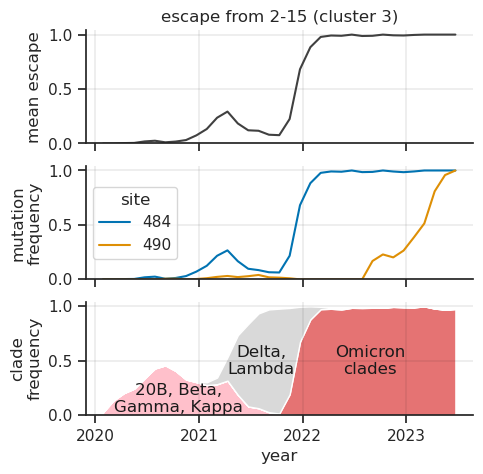

BD55-1962


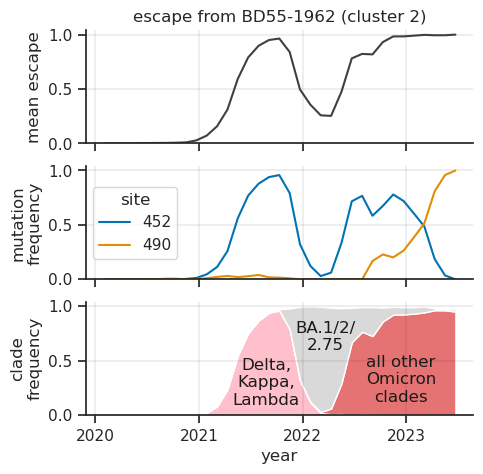

BD56-1797


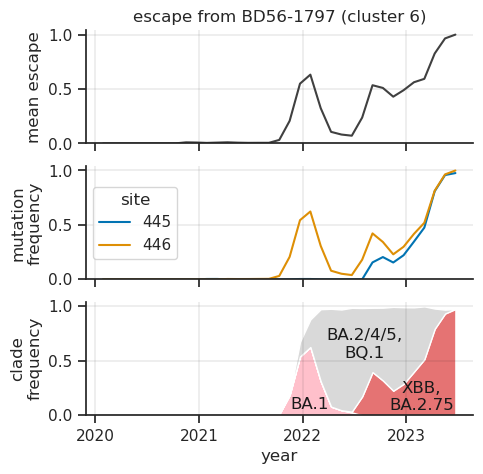

BD-623


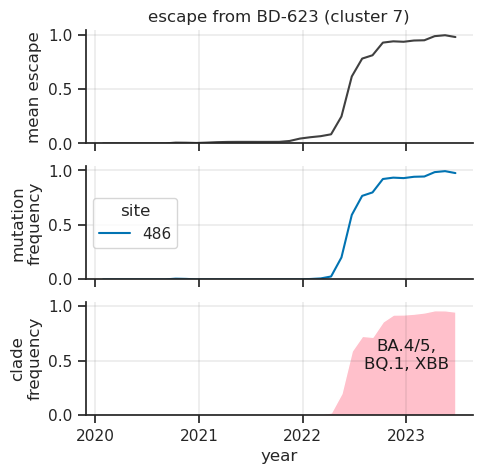

BD-598


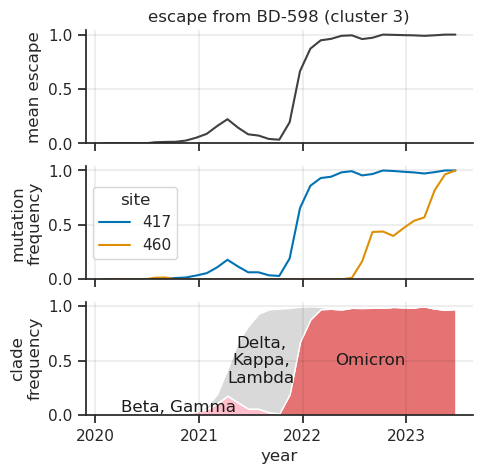

BD-824


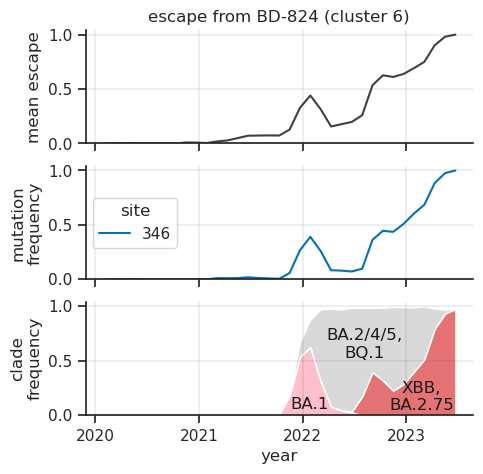

In [39]:
# Plot data
antibodies_to_plot = [
    ('2-15', 3),
    ('BD55-1962', 2),
    ('BD56-1797', 6),
    ('BD-623', 7),
    ('BD-598', '3-417'),
    ('BD-824', 6),
]
for (antibody, cluster) in antibodies_to_plot:
    
    print(antibody)
    (fig, axs) = plt.subplots(
        nrows=3, sharex=True, sharey=True,
        figsize=[5,5]
    )

    # Plot changes in escape score over time
    data = traj_df[traj_df['antibody'] == antibody].copy()
    sns.lineplot(
        x='year', y='mean_escape', data=data, ax=axs[0], c='0.25'
    )
    cluster_int = data['escape_cluster'].unique()[0]
    axs[0].set(
        ylabel=f'mean escape', yticks=[0, 0.5, 1], ylim=[0,1.04],
        title=f'escape from {antibody} (cluster {cluster_int})'
    )

    # Plot changes in mutation frequency
    data = (
        site_escape_df
        .query("antibody == @antibody")
        .merge(mut_freq_df.groupby('site', as_index=False)['mut_freq'].max(), on='site', how='inner')
        .query("normalized_escape > 0.4")
        .query("mut_freq > 0.9")
    )
    sites_to_plot = data['site'].unique()
    sites_to_plot = list(map(str, sites_to_plot))

    data = mut_freq_df.copy()
    data['site'] = data['site'].astype(str)
    data = data[data['site'].isin(sites_to_plot)]
    sns.lineplot(
        x='year', y='mut_freq', data=data, hue='site', ax=axs[1],
    )
    axs[1].set(ylabel='mutation\nfrequency')
    axs[1].legend(loc='center left', title='site')

    # Plot clade frequency
    clade_freqs_df.sort_values('year', inplace=True)
    dfs = []
    for params in clade_plotting_params[cluster]:
        (group_name, clade_strs, text_x, text_y, text_c) = params
        data = clade_freqs_df[
            clade_freqs_df['clade'].isin(clade_strs)
        ].copy()
        if len(data) == 0:
            continue
        data = data.groupby('year').sum(numeric_only=True)
        data['clade'] = group_name
        if group_name == '':
            data['freq'] = 0
        dfs.append(data)
        axs[2].text(
            text_x, text_y, group_name, c=text_c,
            ha='center', va='center'
        )

    clade_group_colors = ['pink', '#E57373', '0.85']
    if len(dfs) == 1:
        axs[2].stackplot(
            dfs[0].index, dfs[0]['freq'],
            colors=['pink'],
            baseline='zero', zorder=0, #alpha=0.5
        )
    else:
        axs[2].stackplot(
            dfs[0].index, dfs[0]['freq'], dfs[1]['freq'], dfs[2]['freq'],
            colors=clade_group_colors,
            baseline='zero', zorder=0, #alpha=0.5
        )
    axs[2].set(
        xlabel='year', ylabel='clade\nfrequency',
        xticks=[2020, 2021, 2022, 2023]
    )
    #axs[1].get_legend(bbox_to_anchor=(1,1))
    for i in range(3):
        axs[i].grid(linewidth=0.1, c='k')

    sns.despine()
    # plt.savefig(f'../results/figures/clade_displacement_{antibody}.png', dpi=300, bbox_inches='tight')
    plt.show()

Analyze the per-clade fitness and frequency of each mutation

In [47]:
# Read in data
fs = sorted(glob.glob('../../SARS2-mut-fitness-v2/results/aamut_fitness/*.csv'))
dfs = []
for f in fs:
    df = pd.read_csv(f)
    clade = os.path.basename(f).replace('_aamut_fitness.csv', '')
    df['clade'] = clade
    dfs.append(df)
fitness_df = pd.concat(dfs)

# Merge with clade names in the dataframe of escape scores
fitness_df['clade'] = fitness_df['clade'].replace('21IJ', '21A/I/J')
fitness_df.rename(columns={'clade':'clade_short'}, inplace=True)
clade_short_df = escape_scores_df.drop_duplicates('clade')[['clade', 'clade_short']]
fitness_df = fitness_df.merge(clade_short_df, on='clade_short', how='left')

# Compute fitness values using the log-ratio method
fitness_df['delta_fitness_bayesian'] = fitness_df['delta_fitness']
pseudo_count = 0.5
fitness_df['delta_fitness'] = fitness_df.apply(
    lambda row: np.log((row['actual_count'] + pseudo_count) / (row['predicted_count'] + pseudo_count)),
    axis=1
)

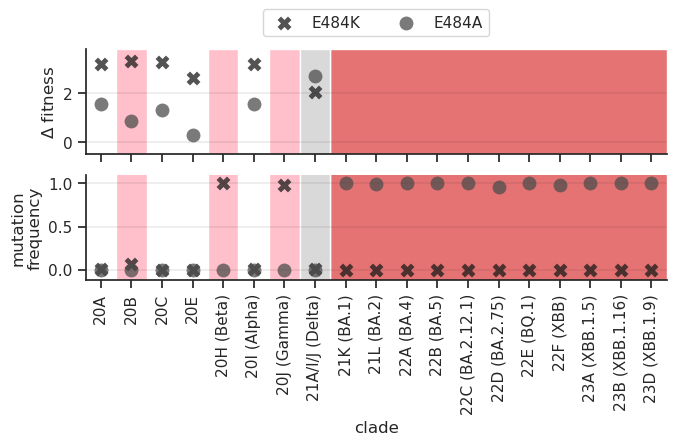

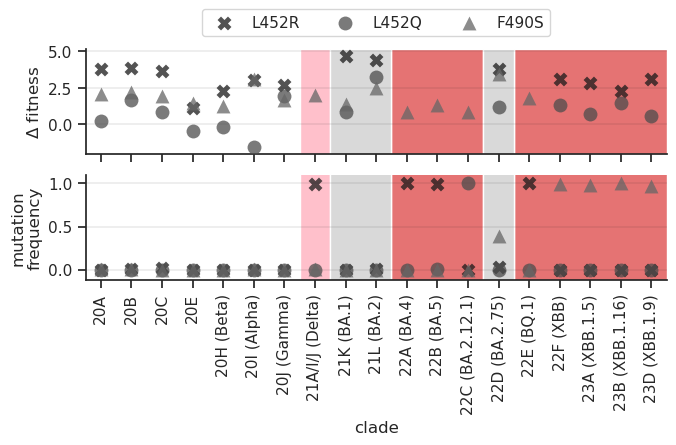

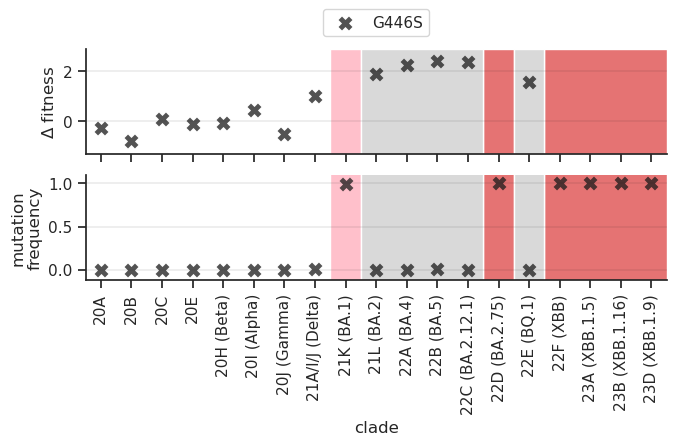

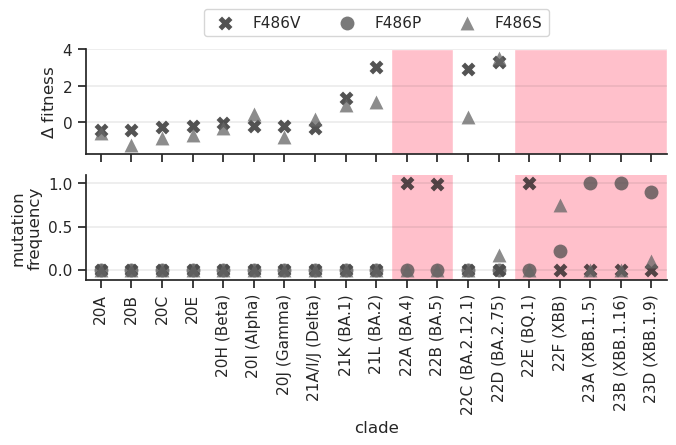

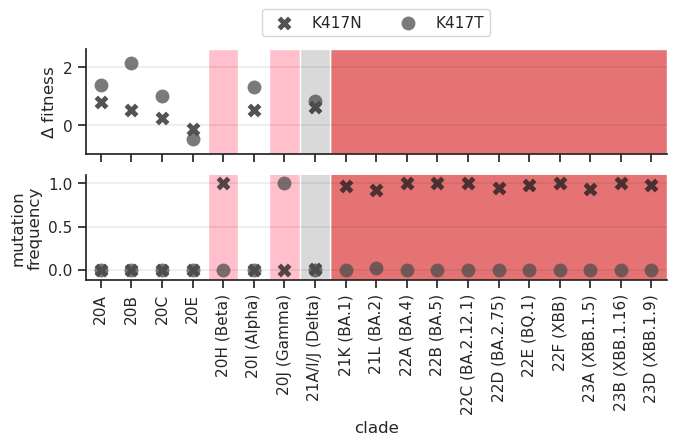

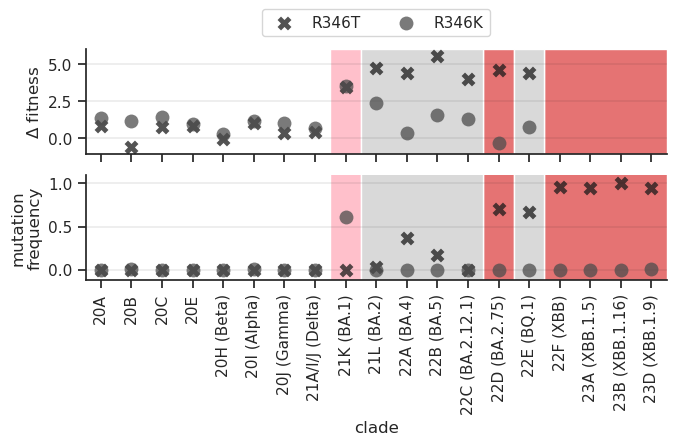

In [48]:
# Initialize varaious variables
markers = ['X', 'o', '^']
colors = ['0.1', '0.3', '0.4']
max_clade_freq_df = clade_freqs_df.groupby('clade', as_index=False)['freq'].max()
freq_cutoff = 0.07
passing_clades = sorted(list(max_clade_freq_df[max_clade_freq_df['freq'] > freq_cutoff]['clade']))
clades_to_ignore = ['19A', '19B']
clades_to_plot = [
    clade for clade in passing_clades # sorted(list(clade_freqs_df['clade'].unique()))
    if clade not in clades_to_ignore
]
#clades_to_plot = sorted(list(clade_freqs_df['clade'].unique()))

# Plot data for below list of mutations
muts_to_plot = [
    (3, ['E484K', 'E484A']), # 'E484Q'
    (2, ['L452R', 'L452Q', 'F490S']), # 
    (6, ['G446S']),
    (7, ['F486V', 'F486P', 'F486S']),
    ('3-417', ['K417N', 'K417T']),
    (6, ['R346T', 'R346K']),
] # ['R408S'] # ['T376A'] # ['R408S'] # ['S375F'] # ['T478K', 'T478R'] # 
for (cluster, muts) in muts_to_plot:
    
    # Compute frequencies of mutations within each clade
    clade_mut_freq_dict = defaultdict(list)
    dfs = []
    for (clade, data) in escape_scores_df.groupby('clade'):
        for mut in muts:
            data = data.drop_duplicates('strain').copy()
            clade_mut_freq_dict['clade'].append(clade)
            clade_mut_freq_dict['aa_mutation'].append(mut)
            clade_mut_freq_dict['mut_freq'].append(
                sum(data['all_aa_substitutions'].str.contains(mut)) / len(data)
            )
    data = pd.DataFrame(clade_mut_freq_dict)
    #data['clade'] = data['clade'].apply(lambda x: x[:3])
    data = data[
        (data['clade'].isin(clades_to_plot))
    ]

    # Get fitness data for the above mutations and clades
    count_cutoff = 0
    fitness_data = fitness_df[
        (fitness_df['gene'] == 'S') &
        (fitness_df['clade'].isin(clades_to_plot)) &
        ((fitness_df['predicted_count'] >= count_cutoff) | (fitness_df['actual_count'] >= count_cutoff)) &
        (fitness_df['aa_mutation'].isin(muts))
    ].copy()
    data.sort_values('clade', inplace=True)
    fitness_data.sort_values('clade', inplace=True)

    # Plot data
    (fig, axs) = plt.subplots(nrows=2, sharex=True, figsize=[7.5,3])

    min_fitness = min(-0.5, fitness_data['delta_fitness'].min() - 0.5)
    max_fitness = fitness_data['delta_fitness'].max() + 0.5

    for (i, mut) in enumerate(muts):
        sns.stripplot(
            x='clade', y='delta_fitness', data=fitness_data[fitness_data['aa_mutation']==mut],
            ax=axs[0],
            order=clades_to_plot, #hue='aa_mutation', hue_order=muts, palette='dark:k',
            s=10, alpha=0.75, dodge=False, marker=markers[i], color=colors[i], #label=mut
        )
        sns.stripplot(
            x='clade', y='mut_freq', data=data[data['aa_mutation']==mut],
            ax=axs[1],
            order=clades_to_plot, #hue='aa_mutation', hue_order=muts, palette='dark:k',
            s=10, alpha=0.75, jitter=False, marker=markers[i], color=colors[i], label=mut
        )

    # Add shaded rectangles
    for (clade_params, facecolor) in zip(clade_plotting_params[cluster], clade_group_colors):
        clades = clade_params[1]
        if len(clades) == 0:
            continue
        rectangle_params = []
        x_start = None
        last_clade_index = -100 # arbitrary large negative number
        for clade in clades:
            if clade not in clades_to_plot:
                continue
            clade_index = clades_to_plot.index(clade)
            if x_start == None:
                x_start = clade_index - 0.5
                last_clade_index = clade_index
            elif clade_index == (last_clade_index + 1):
                last_clade_index = clade_index
            else:
                rectangle_params.append((x_start, last_clade_index - x_start + 0.5))
                x_start = clade_index - 0.5
                last_clade_index = clade_index
        rectangle_params.append((x_start, last_clade_index - x_start + 0.5))
        for (x_start, width) in rectangle_params:
            rect = patches.Rectangle((x_start, min_fitness), width, max_fitness+abs(min_fitness), linewidth=1, facecolor=facecolor, zorder=0)
            axs[0].add_patch(rect)
            rect = patches.Rectangle((x_start, -0.2), width, 1.5, linewidth=1, facecolor=facecolor, zorder=0)
            axs[1].add_patch(rect)

    # Tweak plot
    axs[0].grid(axis='y', linewidth=0.1, c='k')
    axs[1].grid(axis='y', linewidth=0.1, c='k')
    axs[0].set(
        ylabel=r'$\Delta$ fitness',
        ylim=[min_fitness, max_fitness]
    )
    axs[1].set(
        ylabel='mutation\nfrequency',
        ylim=[-0.12, 1.1]
    )
    axs[1].tick_params(labelrotation=90, axis='x')
    handles, labels = axs[1].get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    axs[1].legend(
        by_label.values(), by_label.keys(),
        loc='upper center', ncols=len(muts),
        bbox_to_anchor=(0., 2.55, 1., .102)
    )
    sns.despine()
    # plt.savefig(f'../results/figures/clade_displacement_ff_{muts[0]}.png', dpi=300, bbox_inches='tight')
    plt.show()

In [51]:
clades_to_plot = ['20A', '20B', '20C', '20I (Alpha)']
muts = ['G446S']
fitness_data = fitness_df[
    (fitness_df['gene'] == 'S') &
    #((fitness_df['predicted_count'] >= 10) | (fitness_df['actual_count'] >= 10)) &
    #(fitness_df['clade'].isin(clades_to_plot)) &
    (fitness_df['aa_mutation'].isin(muts))
].copy()

fitness_data[[
    'clade_short', 'aa_mutation', 'expected_count', 'predicted_count', 'actual_count',
    'delta_fitness', 'uncertainty', 'naive_fitness'
]]

clade_short aa_mutation  expected_count  predicted_count  \
104987          20A       G446S          8.2030         8.249750   
226453          20B       G446S          8.1735         8.010381   
347919          20C       G446S          4.6937         4.561748   
469384          20E       G446S          3.0775         3.511808   
590799          20H       G446S          1.1624         1.181222   
712214          20I       G446S         19.6120        21.591055   
833609          20J       G446S          4.1022         3.992413   
955167      21A/I/J       G446S         95.5469        86.124055   
1076561         21I       G446S          9.8419         9.186787   
1197934         21J       G446S         85.7050        76.937268   
1440540         21L       G446S         40.0400        43.106923   
1561867         22A       G446S          6.2600         6.019465   
1683184         22B       G446S         58.2650        52.830019   
1804540         22C       G446S          5.8382         6.437851   
2047103         22E       G446S         17.2640        15.051894   
2655244         all       G446S        260.9744       251.636478   

         actual_count  delta_fitness  uncertainty  naive_fitness  
104987              6      -0.278686     0.647103      -0.291866  
226453              3      -0.812083     0.758607      -0.907509  
347919              5       0.075847     0.674016       0.057302  
469384              3      -0.120404     0.767177      -0.021901  
590799              1      -0.086738     1.105541      -0.102797  
712214             34       0.437794     0.535192       0.539643  
833609              2      -0.509307     0.860207      -0.610244  
955167            232       0.983705     0.512850       0.884054  
1076561            27       1.011113     0.541954       0.977982  
1197934           205       0.971972     0.513361       0.868718  
1440540           288       1.879810     0.533184       1.962406  
1561867            64       2.225700     0.543569       2.255642  
1683184           578       2.375471     0.531633       2.286892  
1804540            76       2.337223     0.541443       2.490696  
2047103            76       1.567979     0.541514       1.460117  
2655244          1305       1.642773     0.515389       1.608005

Compare fitness effects of escape mutations to null distribution of synonymous mutations

In [43]:
# Read in data
fs = sorted(glob.glob('../../SARS2-mut-fitness-v2/results/ntmut_fitness/*.csv'))
dfs = []
for f in fs:
    df = pd.read_csv(f)
    clade = os.path.basename(f).replace('_ntmut_fitness.csv', '')
    df['clade'] = clade.replace('21IJ', '21I/J')
    dfs.append(df)
nt_mut_fitness_df = pd.concat(dfs)

# Compute fitness effects using the log-ratio approach
nt_mut_fitness_df['delta_fitness'] = nt_mut_fitness_df.apply(
    lambda row: np.log((row['actual_count'] + 0.5) / (row['predicted_count'] + 0.5)),
    axis=1
)

E484K
21I/J E484K GA 2.039585334724738 1


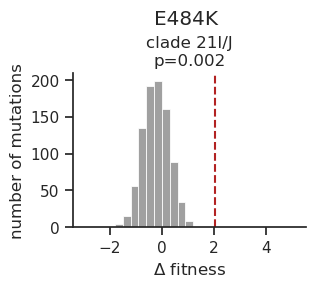

L452R
21K L452R TG 4.826263482597324 1
21L L452R TG 4.572169953862208 1
22D L452R TG 4.231243349297169 1


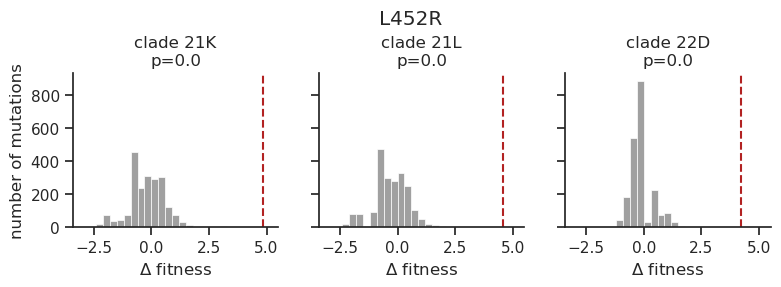

G446S
21L G446S GA 1.8894791717295543 1
22A G446S GA 2.2918728316152395 1
22B G446S GA 2.383939163236813 1
22C G446S GA 2.400298687873 1
22E G446S GA 1.5931083350245272 1


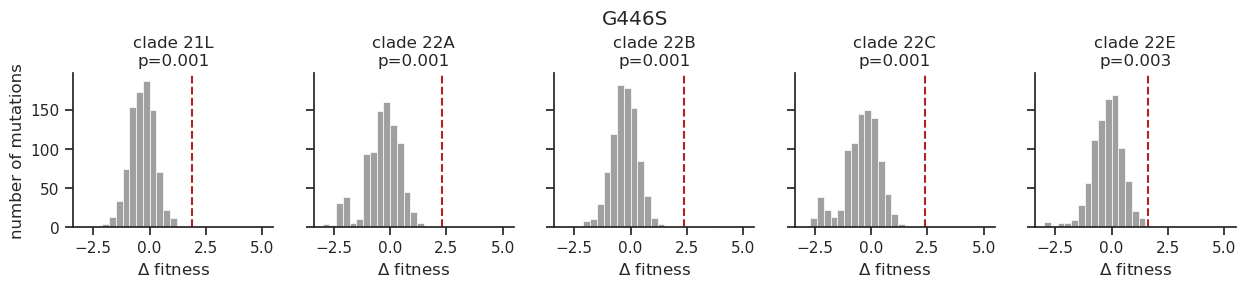

K417N
21I/J K417N GT 0.6635201912664441 2


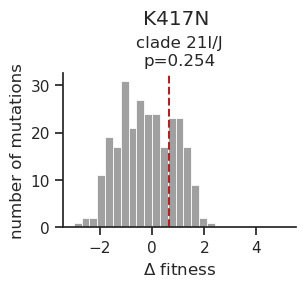

K417T
21I/J K417T AC 0.8504921979833365 1


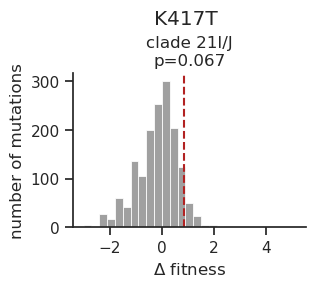

R346K
21L R346K GA 2.376843674394581 1
22A R346K GA 0.3542545228503469 1
22B R346K GA 1.5374253904843578 1
22C R346K GA 1.3316054412446536 1
22E R346K GA 0.7317051530748306 1


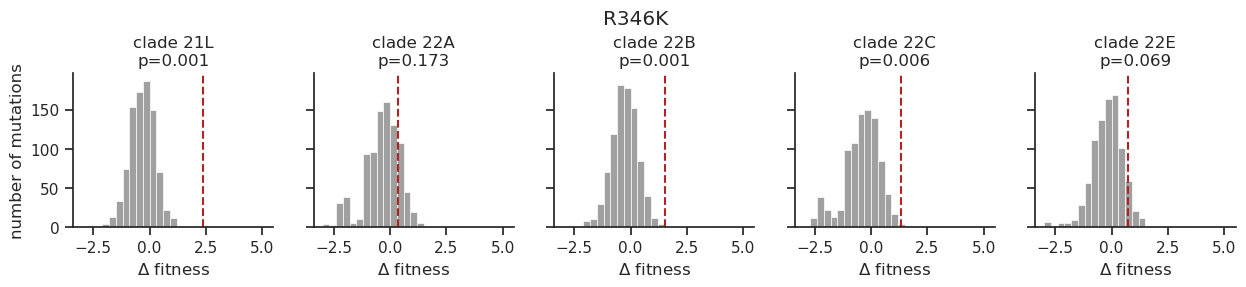

In [53]:
escape_mut_clades = {
    'E484K' : ['21I/J'],
    'L452R' : ('21K', '21L', '22D'),
    'G446S' : ('21L', '22A', '22B', '22C', '22E'),
    'K417N' : ['21I/J'],
    'K417T' : ['21I/J'],
    'R346K' : ('21L', '22A', '22B', '22C', '22E'),
}
metric = 'delta_fitness' # 'f_mean' # 'actual_count' # 

for (escape_mut, clades) in escape_mut_clades.items():

    print(escape_mut)
    (fig, axs) = plt.subplots(
        ncols=len(clades), figsize=[3*len(clades), 2],
        sharex=True, sharey=True
    )
    if len(clades) == 1:
        axs = [axs]

    for (i, clade) in enumerate(clades):

        # Get data for clade
        data = nt_mut_fitness_df[nt_mut_fitness_df['clade'] == clade].copy()
        data['mut_type'] = data['nt_mutation'].apply(lambda x: x[0] + x[-1])
        
        # Get data for escape mut
        escape_data = (
            data[
                (data['gene'] == 'S') &
                (data['aa_mutation'] == escape_mut)
            ].sort_values('actual_count', ascending=False)
        )
        escape_mut_type = escape_data['mut_type'].iloc[0]
        escape_mut_fitness = escape_data[metric].iloc[0]
        print(clade, escape_mut, escape_mut_type, escape_mut_fitness, len(escape_data))
        
        # Get data for synonymous mutations
        syn_data = data[
            (data['synonymous'] == True) &
            (data['mut_type'] == escape_mut_type)
        ].copy().sort_values(metric, ascending=False)
        syn_data['actual_count'] = syn_data['actual_count'].clip(upper=syn_data['actual_count'].quantile(0.95))
        frac = round(sum(syn_data[metric] > escape_mut_fitness) / len(syn_data), 3)

        # Plot data
        bin_size = 0.3
        bins=np.arange(-3, 5+bin_size, bin_size)
        sns.histplot(x=metric, data=syn_data, color='0.5', bins=bins, ax=axs[i])
        axs[i].axvline(escape_mut_fitness, ls='--', c='firebrick')
        axs[i].set(title=f'clade {clade}\np={frac}', xlabel='$\Delta$ fitness')

    axs[0].set(ylabel='number of mutations')
    plt.suptitle(escape_mut, y=1.2)
    sns.despine()
    # plt.savefig(f'../results/figures/fitness_null_{escape_mut}.png', dpi=300, bbox_inches='tight')
    plt.show()

In [47]:
clade = '21I/J'
escape_mut = 'K417N'
data = nt_mut_fitness_df[nt_mut_fitness_df['clade'] == clade].copy()
data['mut_type'] = data['nt_mutation'].apply(lambda x: x[0] + x[-1])

# Get data for escape mut
escape_data = (
    data[
        (data['gene'] == 'S') &
        (data['aa_mutation'] == escape_mut)
    ].sort_values('actual_count', ascending=False)
)
escape_data

cluster  nt_site nt_mutation gene codon_site aa_mutation  synonymous  \
67446    21IJ    22813     G22813T    S        417       K417N       False   
67445    21IJ    22813     G22813C    S        417       K417N       False   

       noncoding  expected_count  predicted_count  actual_count  tau_squared  \
67446      False        283.4780       168.174001           327     1.159601   
67445      False         13.2722         8.964587             4     1.220092   

          f_max  left_conf_int  right_conf_int    f_mean  f_st_dev  clade  \
67446  0.559375       0.876226        1.739759  0.560626  0.984547  21I/J   
67445 -0.736749       1.102373        1.086805 -0.753662  1.089798  21I/J   

       delta_fitness mut_type  
67446        0.66352       GT  
67445       -0.74348       GC

In [ ]:
clade = '22A'
data = nt_mut_fitness_df[
    (nt_mut_fitness_df['clade'] == clade)
].copy()
data['mut_type'] = data['nt_mutation'].apply(lambda x: x[0] + x[-1])
syn_data = data[
    (data['synonymous'] == True) &
    (data['mut_type'] == 'GA')
]

#sns.histplot(x='f_mean', data=syn_data)
syn_data.sort_values('f_mean').head(n=20)

cluster  nt_site nt_mutation          gene codon_site    aa_mutation  \
77844     22A    26352     G26352A             E         36           A36A   
39610     22A    13539     G13539A        ORF1ab       4425         R4425R   
12586     22A     4486      G4486A  ORF1a;ORF1ab  1407;1407  K1407K;K1407K   
87497     22A    29593     G29593A         ORF10         12           T12T   
65013     22A    22051     G22051A             S        163          A163A   
35675     22A    12223     G12223A  ORF1a;ORF1ab  3986;3986  V3986V;V3986V   
68307     22A    23161     G23161A             S        533          L533L   
40492     22A    13836     G13836A        ORF1ab       4524         R4524R   
55641     22A    18903     G18903A        ORF1ab       6213         K6213K   
67479     22A    22882     G22882A             S        440          K440K   
28627     22A     9856      G9856A  ORF1a;ORF1ab  3197;3197  V3197V;V3197V   
29211     22A    10051     G10051A  ORF1a;ORF1ab  3262;3262  L3262L;L3262L   
38140     22A    13045     G13045A  ORF1a;ORF1ab  4260;4260  V4260V;V4260V   
42061     22A    14364     G14364A        ORF1ab       4700         L4700L   
54507     22A    18525     G18525A        ORF1ab       6087         V6087V   
77763     22A    26325     G26325A             E         27           L27L   
83334     22A    28193     G28193A          ORF8        100          V100V   
78943     22A    26720     G26720A             M         66           V66V   
68271     22A    23149     G23149A             S        529          K529K   
40231     22A    13749     G13749A        ORF1ab       4495         K4495K   

       synonymous  noncoding  expected_count  predicted_count  actual_count  \
77844        True      False            6.26        10.610533             0   
39610        True      False            6.26         9.361507             0   
12586        True      False            6.26         7.111626             0   
87497        True      False            6.26         7.730000             0   
65013        True      False            6.26         7.730000             0   
35675        True      False            6.26         6.062518             0   
68307        True      False            6.26         6.062518             0   
40492        True      False            6.26         6.027296             0   
55641        True      False            6.26         4.577286             0   
67479        True      False            6.26         4.577286             0   
28627        True      False            6.26         3.901154             0   
29211        True      False            6.26         3.901154             0   
38140        True      False            6.26         3.901154             0   
42061        True      False            6.26         3.901154             0   
54507        True      False            6.26         3.901154             0   
77763        True      False            6.26         3.901154             0   
83334        True      False            6.26         3.901154             0   
78943        True      False            6.26         3.901154             0   
68271        True      False            6.26         3.756178             0   
40231        True      False            6.26         3.756178             0   

       tau_squared     f_max  left_conf_int  right_conf_int    f_mean  \
77844     0.460682 -3.042604       1.597950        1.161238 -3.438903   
39610     0.809549 -2.914014       1.642929        1.283484 -3.245661   
12586     0.289238 -2.773119       1.616598        1.142590 -3.231790   
87497     0.493747 -2.817603       1.655726        1.187075 -3.221895   
65013     0.493747 -2.817603       1.655726        1.187075 -3.221895   
35675     0.299699 -2.660407       1.562086        1.197103 -3.124134   
68307     0.299699 -2.660407       1.562086        1.197103 -3.124134   
40492     0.399837 -2.652450       1.653654        1.189147 -3.090599   
55641     0.335494 -2.465600       1.673279       

In [ ]:
nt_mut_fitness_df[
    (nt_mut_fitness_df['nt_mutation'] == 'G26352A') &
    (nt_mut_fitness_df['clade'].isin(['22A', '22B']))
]

cluster  nt_site nt_mutation gene codon_site aa_mutation  synonymous  \
77844     22A    26352     G26352A    E         36        A36A        True   
77797     22B    26352     G26352A    E         36        A36A        True   

       noncoding  expected_count  predicted_count  actual_count  tau_squared  \
77844      False           6.260        10.610533             0     0.460682   
77797      False          58.265        93.124252             4     0.460682   

          f_max  left_conf_int  right_conf_int    f_mean  f_st_dev clade  
77844 -3.042604       1.597950        1.161238 -3.438903  1.458994   22A  
77797 -2.899584       0.821689        0.754589 -2.932091  0.797880   22B

Examine effects of mutations on ACE2 binding

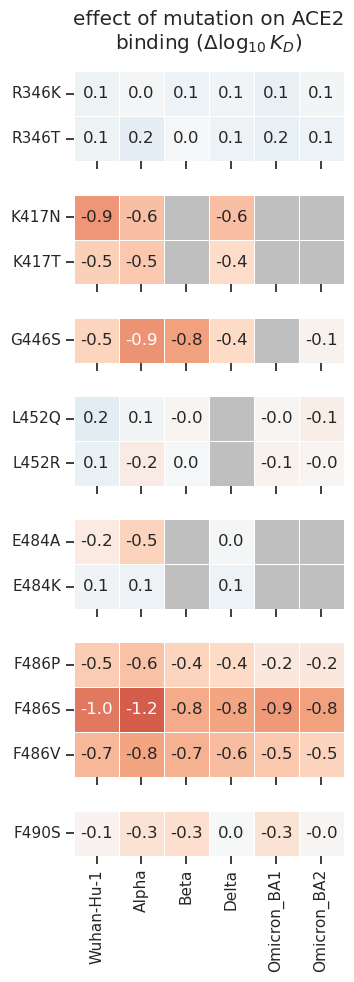

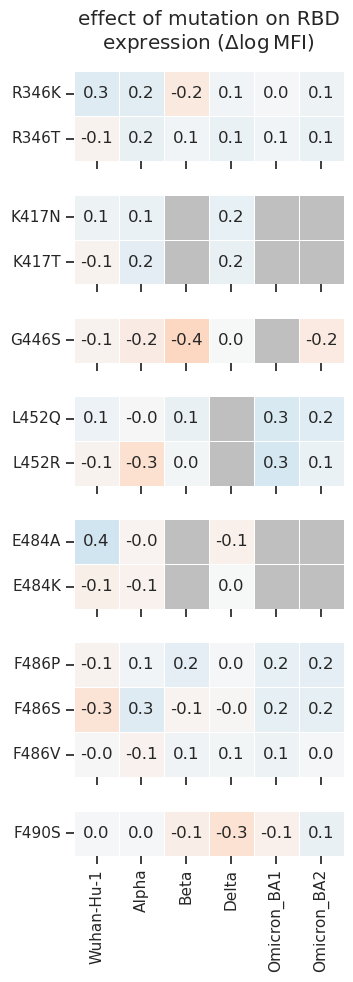

In [ ]:
# Read in data
f = 'https://media.githubusercontent.com/media/jbloomlab/SARS-CoV-2-RBD_DMS_Omicron/refs/heads/main/results/final_variant_scores/final_variant_scores.csv'
rbd_dms_df = pd.read_csv(f)
rbd_dms_df['target'] = rbd_dms_df['target'].replace('Wuhan-Hu-1_v2', 'Wuhan-Hu-1')

# List groups of mutations and variants to plot
mut_groups = [
    ['R346K', 'R346T'],
    ['K417N', 'K417T'],
    ['G446S'],
    ['L452Q', 'L452R'],
    ['E484A', 'E484K'],
    ['F486P', 'F486S', 'F486V'],
    ['F490S'],
]
all_muts = []
for mut_group in mut_groups:
    all_muts.extend(mut_group)
variants = ['Wuhan-Hu-1', 'Alpha', 'Beta', 'Delta', 'Omicron_BA1', 'Omicron_BA2']

# Make one plot each for mutational effects on binding and expression
dms_metrics = ['delta_bind', 'delta_expr']
titles = {
    'delta_bind' : 'effect of mutation on ACE2\nbinding ($\Delta\log_{10}K_{D})$',
    'delta_expr' : 'effect of mutation on RBD\nexpression ($\Delta\log$MFI)'
}
cmap_range = {
    'delta_bind' : [-4, 2],
    'delta_expr' : [-4, 1]
}
for dms_metric in dms_metrics:

    # Make a matrix of dms data for the above mutations and variants
    data = (
        rbd_dms_df[rbd_dms_df['mutation'].isin(all_muts)]
        .pivot_table(index='mutation', columns='target', values=dms_metric)[variants]
    )

    # Plot data for one group of mutations per subplot
    height_ratios = [len(mut_group) for mut_group in mut_groups]
    (fig, axs) = plt.subplots(
        figsize=[10,10], nrows=len(mut_groups), sharex=True,
        gridspec_kw={'height_ratios':height_ratios}
    )
    for (i, mut_group) in enumerate(mut_groups):
        data_i = data.loc[mut_group]
        (vmin, vmax) = (-2, 2)# cmap_range[dms_metric]
        #norm = TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax)
        sns.heatmap(
            data_i, annot=True, fmt='.1f',
            cmap='RdBu', vmin=vmin, vmax=vmax, square=True, cbar=False, #norm=norm,
            linewidths=0.5, mask=data_i.isnull(),
            ax=axs[i]
        )
        axs[i].set_facecolor('0.75')
        axs[i].set(xlabel='', ylabel='')
        axs[i].tick_params('y', labelrotation=0)

    plt.suptitle(titles[dms_metric])
    plt.tight_layout(h_pad=2)
    # plt.savefig(f'../results/figures/mut_effect_rbd_dms_{dms_metric}.png', dpi=300, bbox_inches='tight')
    plt.show()

In [ ]:
fitness_df[
    (fitness_df['gene'] == 'S') &
    (fitness_df['aa_mutation'] == 'K417T')
]

cluster gene clade_founder_aa mutant_aa  aa_site aa_mutation  \
104773      20A    S                K         T      417       K417T   
226239      20B    S                K         T      417       K417T   
347705      20C    S                K         T      417       K417T   
469170      20E    S                K         T      417       K417T   
712000      20I    S                K         T      417       K417T   
954793      21J    S                K         T      417       K417T   
2412064     all    S                K         T      417       K417T   

         expected_count  predicted_count  actual_count  tau_squared  \
104773          0.96873         1.553902             9     0.410656   
226239          0.47407         1.508814            20     0.410656   
347705          0.25926         0.859226             4     0.410656   
469170          0.25371         0.661463             0     0.410656   
712000          1.25410         4.066751            18     0.410656   
954793          5.90070        14.491885            38     0.410656   
2412064        10.10816        26.006261            91     0.410656   

         naive_fitness  subset_of_ORF1ab  delta_fitness  uncertainty clade3  \
104773        1.866894             False       1.568469     0.699153    20A   
226239        3.046697             False       2.383719     0.655482    20B   
347705        1.779488             False       1.271684     0.796858    20C   
469170       -0.410400             False      -1.806465     1.746126    20E   
712000        2.355815             False       1.358456     0.659437    20I   
954793        1.794251             False       0.889011     0.638744    21J   
2412064       2.154715             False       1.168608     0.627831    all   

               clade  
104773           20A  
226239           20B  
347705           20C  
469170           20E  
712000   20I (Alpha)  
954793   21J (Delta)  
2412064          NaN

20A 16312 0.016 0.001


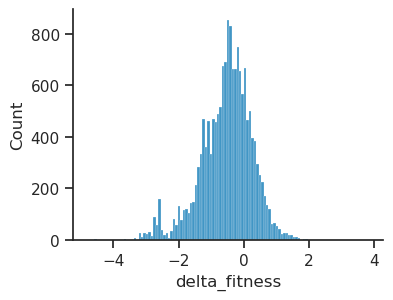

20B 16311 0.013 0.001


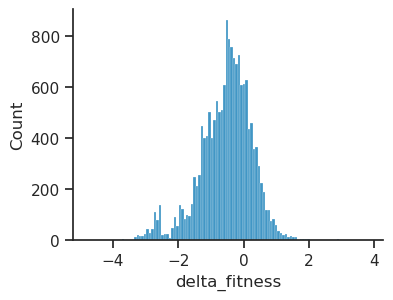

20C 16312 0.018 0.002


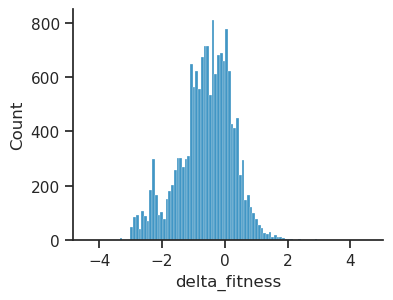

20E 16312 0.016 0.001


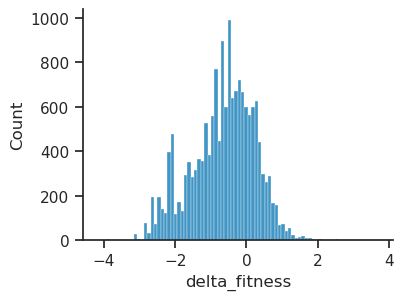

20H 16306 0.027 0.002


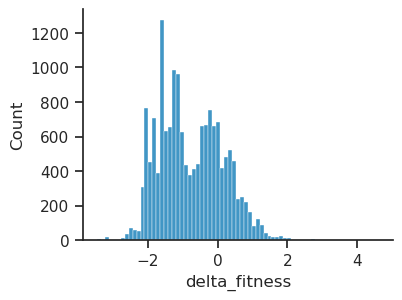

20I 16301 0.011 0.001


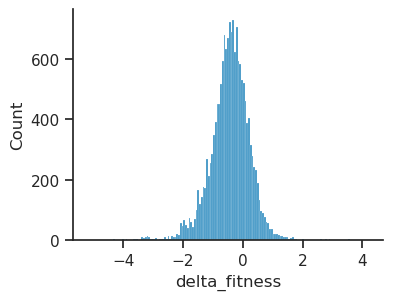

20J 16297 0.017 0.001


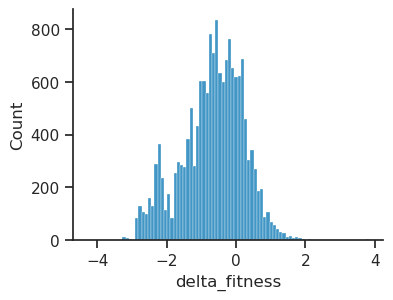

21J 16305 0.01 0.001


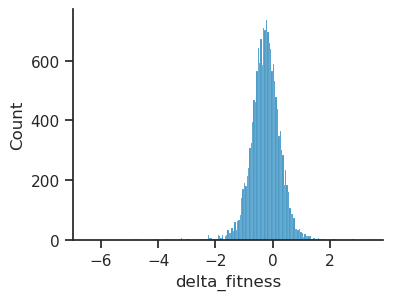

21K 16278 0.014 0.001


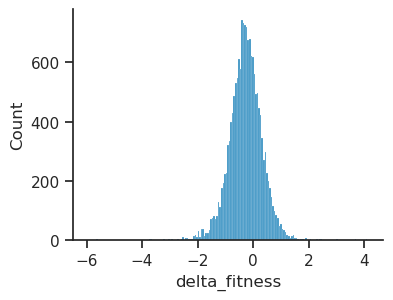

21L 16299 0.011 0.001


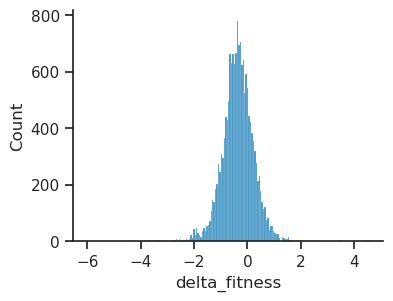

22A 16289 0.014 0.001


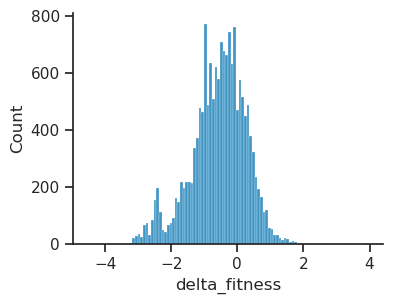

22B 16287 0.013 0.001


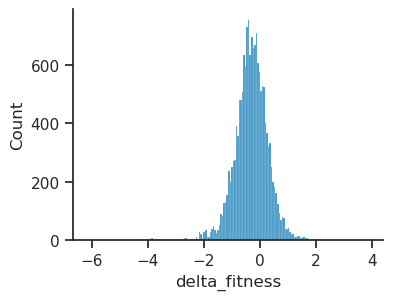

22C 16296 0.02 0.002


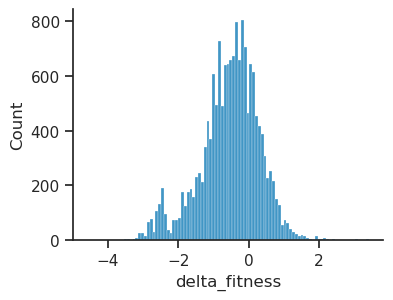

22D 16288 0.021 0.001


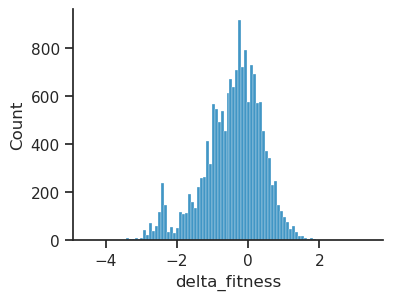

22E 16289 0.017 0.001


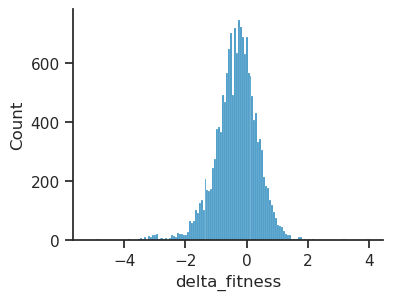

22F 16292 0.021 0.001


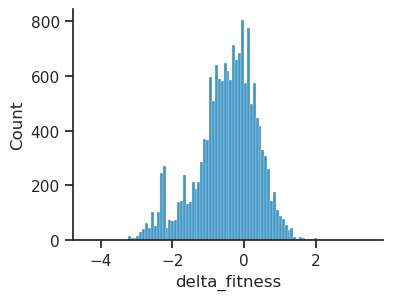

23A 16298 0.014 0.0


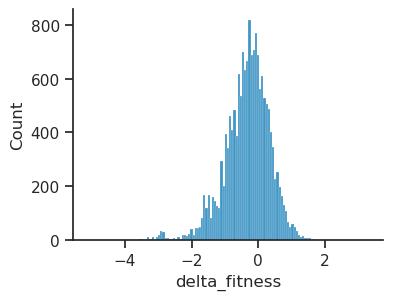

23B 16293 0.018 0.001


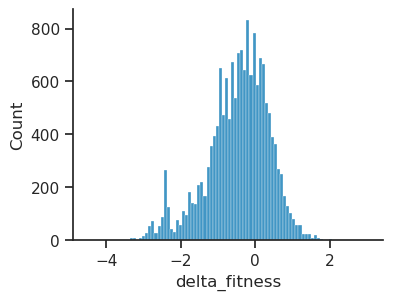

23D 16297 0.015 0.001


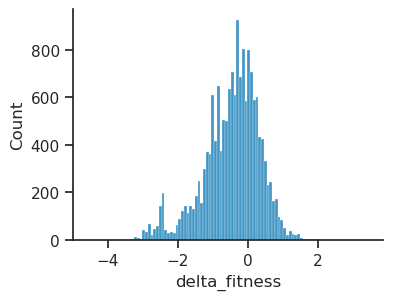

all 16586 0.011 0.001


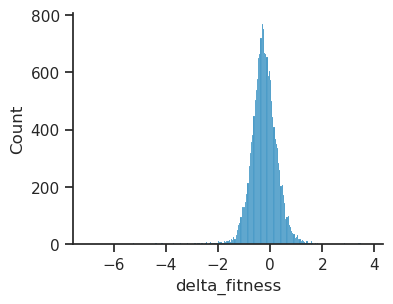

In [ ]:
fitness_df['synonymous'] = fitness_df['clade_founder_aa'] == fitness_df['mutant_aa']
for (cluster, cluster_data) in fitness_df.groupby('cluster'):
    data = cluster_data[cluster_data['synonymous'] == True]
    print(
        cluster, len(data),
        round(sum(data['delta_fitness'] >= 1)/len(data), 3),
        round(sum(data['delta_fitness'] >= 2)/len(data), 3)
    )
    plt.figure(figsize=[4,3])
    sns.histplot(x='delta_fitness', data=data)
    sns.despine()
    plt.show()

Examine the distribution of fitness effects of synonymous mutations in updated repo

In [ ]:
fs = sorted(glob.glob('../../test/SARS2-refined-fitness/results/aamut_fitness/*.csv'))
dfs = []
for f in fs:
    df = pd.read_csv(f)
    clade = os.path.basename(f).replace('_aamut_fitness.csv', '')
    df['clade'] = clade
    dfs.append(df)
fitness_df = pd.concat(dfs)

20H 16306 0.027 0.002


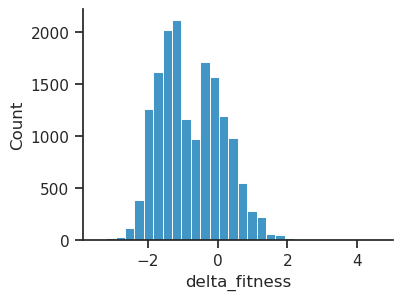

In [ ]:
fitness_df['synonymous'] = fitness_df['clade_founder_aa'] == fitness_df['mutant_aa']
for (cluster, cluster_data) in fitness_df.groupby('cluster'):
    data = cluster_data[cluster_data['synonymous'] == True]
    print(
        cluster, len(data),
        round(sum(data['delta_fitness'] >= 1)/len(data), 3),
        round(sum(data['delta_fitness'] >= 2)/len(data), 3)
    )
    plt.figure(figsize=[4,3])
    sns.histplot(x='delta_fitness', data=data, bins=30)
    sns.despine()
    plt.show()
    break

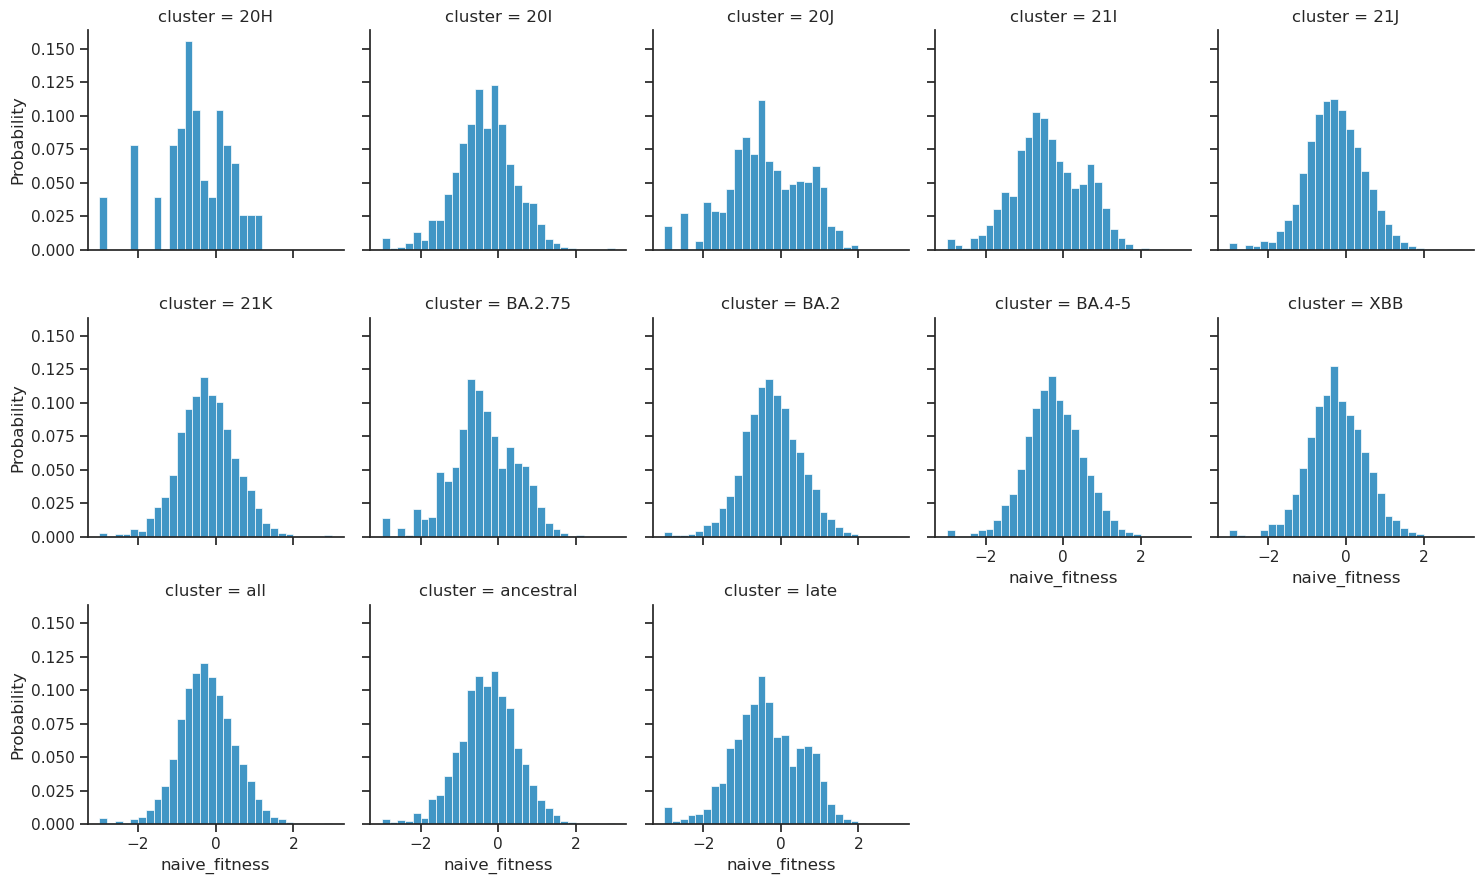

In [ ]:
(count_col, fitness_col) = ('expected_count', 'naive_fitness') # ('predicted_count', 'delta_fitness')
data = fitness_df[
    (fitness_df[count_col] > 10) &
    (fitness_df['synonymous'] == True)
].copy()
data.sort_values('cluster')
data[fitness_col] = data[fitness_col].clip(lower=-3, upper=3)
bins = np.arange(-3,3.2,0.2)
g = sns.FacetGrid(data, col="cluster", col_wrap=5)
g.map_dataframe(sns.histplot, x=fitness_col, bins=bins, stat='probability')

In [ ]:
data[data['cluster'] == 'all']['delta_fitness'].mean()

-0.226950578808206

In [ ]:
data[data['cluster'] == '20H'].sort_values('delta_fitness').head(n=20)

cluster          gene clade_founder_aa mutant_aa  aa_site aa_mutation  \
121022     20H             N                F         F      403       F403F   
46004      20H        ORF1ab                Y         Y     6416      Y6416Y   
112680     20H         ORF3a                H         H      247       H247H   
117852     20H         ORF9b                N         N       55        N55N   
110261     20H             S                D         D     1184      D1184D   
115558     20H         ORF7a                H         H       19        H19H   
30675      20H        ORF1ab                Y         Y     4280      Y4280Y   
71114      20H          nsp4                Y         Y       46        Y46Y   
119796     20H             N                S         S      232       S232S   
116338     20H         ORF7b                D         D        8         D8D   
113174     20H             E                Y         Y       42        Y42Y   
96881      20H         nsp14                Y         Y      491       Y491Y   
117711     20H         ORF9b                N         N       35        N35N   
81552      20H         nsp10                Y         Y       27        Y27Y   
84311      20H  nsp12 (RdRp)                F         F      275       F275F   
36774      20H        ORF1ab                D         D     5132      D5132D   
117927     20H         ORF9b                D         D       66        D66D   
107321     20H             S                N         N      777       N777N   
118726     20H             N                D         D       82        D82D   
33434      20H        ORF1ab                F         F     4667      F4667F   

        expected_count  predicted_count  actual_count  tau_squared  \
121022          5.0918         7.467545             0     0.616813   
46004           5.0918         7.357707             0     0.485460   
112680          5.0918         7.357707             0     0.485460   
117852          5.0918         7.357707             0     0.485460   
110261          5.0918         6.712246             0     0.397690   
115558          5.0918         6.751758             0     0.509116   
30675           5.0918        11.099205             0     0.550384   
71114           5.0918        11.099205             0     0.550384   
119796          5.0918         6.579874             0     0.566943   
116338          5.0918         6.751758             0     0.509116   
113174          5.0918         6.751758             0     0.509116   
96881           5.0918         7.357707             0     0.485460   
117711          5.0918         7.357707             0     0.485460   
81552           5.0918        11.099205             0     0.550384   
84311           5.0918         8.137682             0     0.495212   
36774           5.0918         6.751758             0     0.509116   
117927          5.0918         7.357707             0     0.485460   
107321          5.0918         7.357707             0     0.485460   
118726          5.0918         6.712246             0     0.397690   
33434           5.0918         8.137682             0     0.495212   

        naive_fitness  subset_of_ORF1ab  delta_fitness  uncertainty clade  \
121022      -2.414448             False           -3.0     1.520570   20H   
46004       -2.414448             False           -3.0     1.497143   20H   
112680      -2.414448             False           -3.0     1.497143   20H   
117852      -2.414448             False           -3.0     1.497143   20H   
110261      -2.414448             False           -3.0     1.488647   20H   
115558      -2.414448             False           -3.0     1.509635   20H   
30675       -2.414448             False           -3.0     1.473286   20H   
71114       -2.414448              True           -3.0     1.473286   20H   
119796      -2.414448             False           -3.0     1.522791   20H   
116338      -2.414448             False           -3.0     1.509635   20H   
113174  

Observations
* B38 from group A
    * alpha has the N501Y escape mutation (escape score of 0.27)
    * beta and gamma have the K417N, E484K, and N501Y escape mutations
    * delta lacks  these mutations
    * omicron has the K417N, E484A, N501Y escape mutations
    * the above mutations spike and dip at the same time as the average-escape plot
* 2-15 from group C
    * same as above, but for the 484 mutation?

* BD-623 from group B
    * escape at 486

* 1-57 from group D1
    * escape patterns track with mutations at 446 (G446S?)
    * BA.1 has this mutation, BA.2 does not, but then it occurs later on in omicron evolution    
* BD55-1962 from group D1
    * escape at 452
    
* BD55-1036 from group D2
    * escape at 445
* BD55-1104 from group D2
    * escape at 444, 445, 446
    
* BD55-1245 from group E1
    * escape at 371, 373
    
* BD-713 from group E2.1
    * escape at 346, 452, 484
    * accumulation of multiple partial-escape mutations
* BD-744 from group E2.1
    * escape at 346, 452
    * interesting tradeoff between mutations
* BD55-1312 from group E2.1
    * escape at 484, 490
    * accumulation of multiple partial-escape mutations
* BD-901 from group E2.1
    * escape at 346, 376, 490
    * accumulation of multiple partial-escape mutations
    
* ADG-2 from group F3
    * escape at 408 with partial escape at 484, 505
* BD55-5259 from group F3
    * partial escape at 375, 505
* BD55-5448 from group F3
    * partial escape at many sites: 405, 408, 484, 496, 501, 505

## Extra code

For each antibody, identify escape mutations that are correlated with its escape trajectory.

In [ ]:
# Iterate over each antibody and compute correlations
all_mut_sites = mut_freq_df['site'].unique()
dfs = []
for ((cluster, antibody), data) in traj_df.groupby(['escape_cluster', 'antibody']):

    # Merge escape trajectory data for antibody with mut freqs and DMS data
    data = (
        data
        .merge(mut_freq_df, on=['time', 'year'], how='left')
        .merge(
            site_escape_df.rename(columns = {'escape':'site_escape'}),
            on=['antibody', 'site'], how='left'
        )
    )
    data['site_escape'] = data['site_escape'].fillna(0)

    # Make a list of sites with escape scores above a threshold and where
    # mutations are observed in natural isolates
    sites = data[
        (data['mut_freq'].notnull()) &
        (data['site_escape'] > 0.2)
    ]['site'].unique()
    if len(sites) == 0:
        continue

    # Compute stats quantifying trends between mut freqs and escape score,
    # ignoring mutations that don't reach a frequency threshold
    corr_dict = defaultdict(list)
    for site in sites:
        data_i = data[data['site'] == site]
        max_freq = round(data_i['mut_freq'].max(), 2)
        if max_freq < 0.2:
            continue
        r = round(data_i['mean_escape'].corr(data_i['mut_freq']), 2)
        corr_dict['cluster'].append(cluster)
        corr_dict['antibody'].append(antibody)
        corr_dict['site'].append(site)
        corr_dict['max_freq'].append(max_freq)
        corr_dict['r'].append(r)
    corr_df = pd.DataFrame(corr_dict)
    if len(corr_df) == 0:
        continue

    # Merge with site-escape data
    corr_df = corr_df.merge(site_escape_df.rename(columns = {'escape':'site_escape'}), on=['antibody', 'site'], how='left')
    corr_df['site_escape'] = corr_df['site_escape'].fillna(0)
    dfs.append(corr_df)

escape_mut_corr_df = pd.concat(dfs)
escape_mut_corr_df.head()

cluster antibody  site  max_freq     r  site_escape           study  \
0        1   BD-670   446      1.00  0.67     2.682674  imprinted_2022   
1        1   BD-670   452      0.96  0.49     4.263748  imprinted_2022   
2        1   BD-670   484      1.00  0.93     8.269362  imprinted_2022   
3        1   BD-670   486      0.99  0.70     7.975429  imprinted_2022   
4        1   BD-670   490      1.00  0.48     7.840567  imprinted_2022   

   normalized_escape  kmeans_cluster  escape_cluster  
0           0.324411              15               1  
1           0.515608              15               1  
2           1.000000              15               1  
3           0.964455              15               1  
4           0.948147              15               1

For each cluster, count the number of times a given site is:
* correlated with an antibody's escape trajectory
* reaches an appreciable frequency in nature
* has an appreciably large site-escape score from DMS

In [ ]:
for (cluster, data) in escape_mut_corr_df.groupby('cluster'):
    if cluster not in [3, 5]:
        continue
    data = data[
        (data['r'] > 0.2) &
        (data['max_freq'] > 0.3) &
        (data['site_escape'] > 0.3)
    ]
    print('\n')
    print('cluster:', cluster)
    print('n antibodies:', len(data['antibody'].unique()))
    print(data['site'].value_counts())



cluster: 3
n antibodies: 199
484    159
490    111
417     73
493     66
486     42
452     38
460     36
496     35
346     33
501     31
405     28
408     25
446     20
498     12
505     12
445      9
371      6
440      5
376      5
477      4
375      3
339      3
373      2
478      1
Name: site, dtype: int64


cluster: 5
n antibodies: 83
452    80
484    62
490    59
346    57
446    36
371     6
445     6
405     6
486     5
496     5
376     4
339     4
478     3
501     3
460     3
477     3
440     2
498     2
493     1
375     1
Name: site, dtype: int64


In [ ]:
# Get data to plot
groups_to_plot = [
    (1, 'C'),
    (1, 'D1'),

    (2, 'D1'),
    
    (3, 'A'),
    (3, 'C'),

    (4, 'A'),
    (4, 'B'),

    (5, 'E2.2'),
    (5, 'F2'),

    (6, 'C'),
    (6, 'D1'),
    (6, 'E2.1'),

    (7, 'D1'),
    (7, 'D2'),
    (7, 'E1'),
    (7, 'E2.1'),

    (9, 'B'),
]

dms_df['group'] = dms_df.apply(lambda row: (row['escape_cluster'], row['epitope_cluster']), axis=1)
data_to_plot = dms_df[dms_df['group'].isin(groups_to_plot)]

# Add entries of zero for missing mutations
null_dict = defaultdict(list)
for site in data_to_plot['site'].unique():
    for mutation in data_to_plot['mutation'].unique():
        null_dict['site'].append(site)
        null_dict['mutation'].append(mutation)
        null_dict['normalized_mut_escape'].append(0.0)
null_df = pd.DataFrame(null_dict)
dfs = []
for ((group, ab), ab_data) in data_to_plot.groupby(['group', 'antibody']):
    null_data = null_df.copy()
    null_data['group'] = [group] * len(null_data)
    null_data['antibody'] = ab
    ab_data = (
        pd.concat([null_data, ab_data])
        .groupby(['group', 'antibody', 'site', 'mutation'], as_index=False)['normalized_mut_escape'].sum()
    )
    dfs.append(ab_data)
data_to_plot = pd.concat(dfs)

# Get average normalized mutation-level escape scores
data_to_plot = (
    data_to_plot
    .groupby(['group', 'site', 'mutation'], as_index=False)
    .agg(
        mean_normalized_mut_escape = ('normalized_mut_escape', 'mean'),
    )
    .assign(group_title = lambda x: x['group'].map(lambda y: f'cluster {y[0]}, epitope {y[1]}'))
)
data_to_plot['escape_cluster'] = data_to_plot['group'].apply(lambda x: x[0])
data_to_plot = data_to_plot[data_to_plot['escape_cluster'].isin([1, 2, 3, 4, 6, 7, 9])]

# Identify which sites to plot
site_data = data_to_plot.groupby(['group_title', 'site'], as_index=False)['mean_normalized_mut_escape'].sum()
sites_to_plot = list(site_data[
    (site_data['mean_normalized_mut_escape'] > 0.3)
]['site'])
print(len(sites_to_plot))
data_to_plot = data_to_plot[data_to_plot['site'].isin(sites_to_plot)]

data_to_plot

48


group  site mutation  mean_normalized_mut_escape  \
260       (1, C)   346        A                    0.013103   
261       (1, C)   346        C                    0.000000   
262       (1, C)   346        D                    0.006321   
263       (1, C)   346        E                    0.010611   
264       (1, C)   346        F                    0.003970   
...          ...   ...      ...                         ...   
33975  (6, E2.1)   494        S                    0.000000   
33976  (6, E2.1)   494        T                    0.000000   
33977  (6, E2.1)   494        V                    0.000087   
33978  (6, E2.1)   494        W                    0.000185   
33979  (6, E2.1)   494        Y                    0.000000   

                   group_title  escape_cluster  
260       cluster 1, epitope C               1  
261       cluster 1, epitope C               1  
262       cluster 1, epitope C               1  
263       cluster 1, epitope C               1  
264       cluster 1, epitope C               1  
...                        ...             ...  
33975  cluster 6, epitope E2.1               6  
33976  cluster 6, epitope E2.1               6  
33977  cluster 6, epitope E2.1               6  
33978  cluster 6, epitope E2.1               6  
33979  cluster 6, epitope E2.1               6  

[4400 rows x 6 columns]

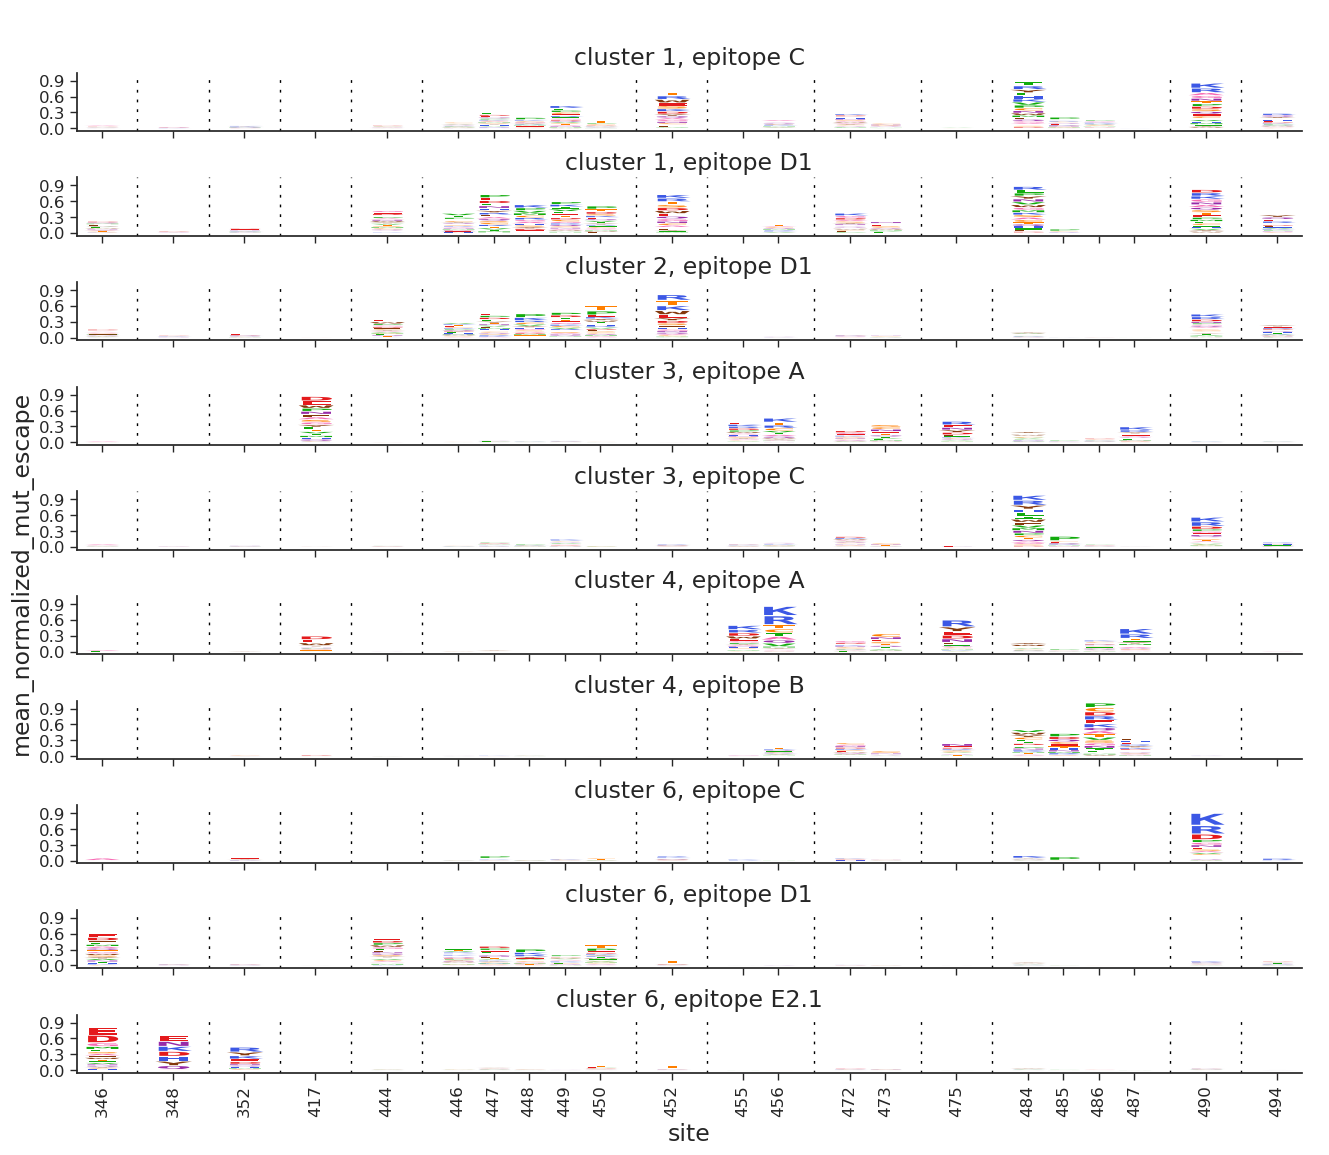

In [ ]:
# Make plot
(fig, axes) = dmslogo.facet_plot(
    data_to_plot, #[data_to_plot['escape_cluster'] == 5],
    gridrow_col="group_title",
    x_col="site",
    show_col=None,
    share_ylim_across_rows=True,
    draw_logo_kwargs=dict(
        letter_col="mutation", letter_height_col="mean_normalized_mut_escape",
        xlabel="site",
    ),
    height_per_ax=1,
    #line_titlesuffix="site-level selection",
    #logo_titlesuffix="mutation-level selection",
)
plt.show()

Examine DMS profiles of specific antibodies

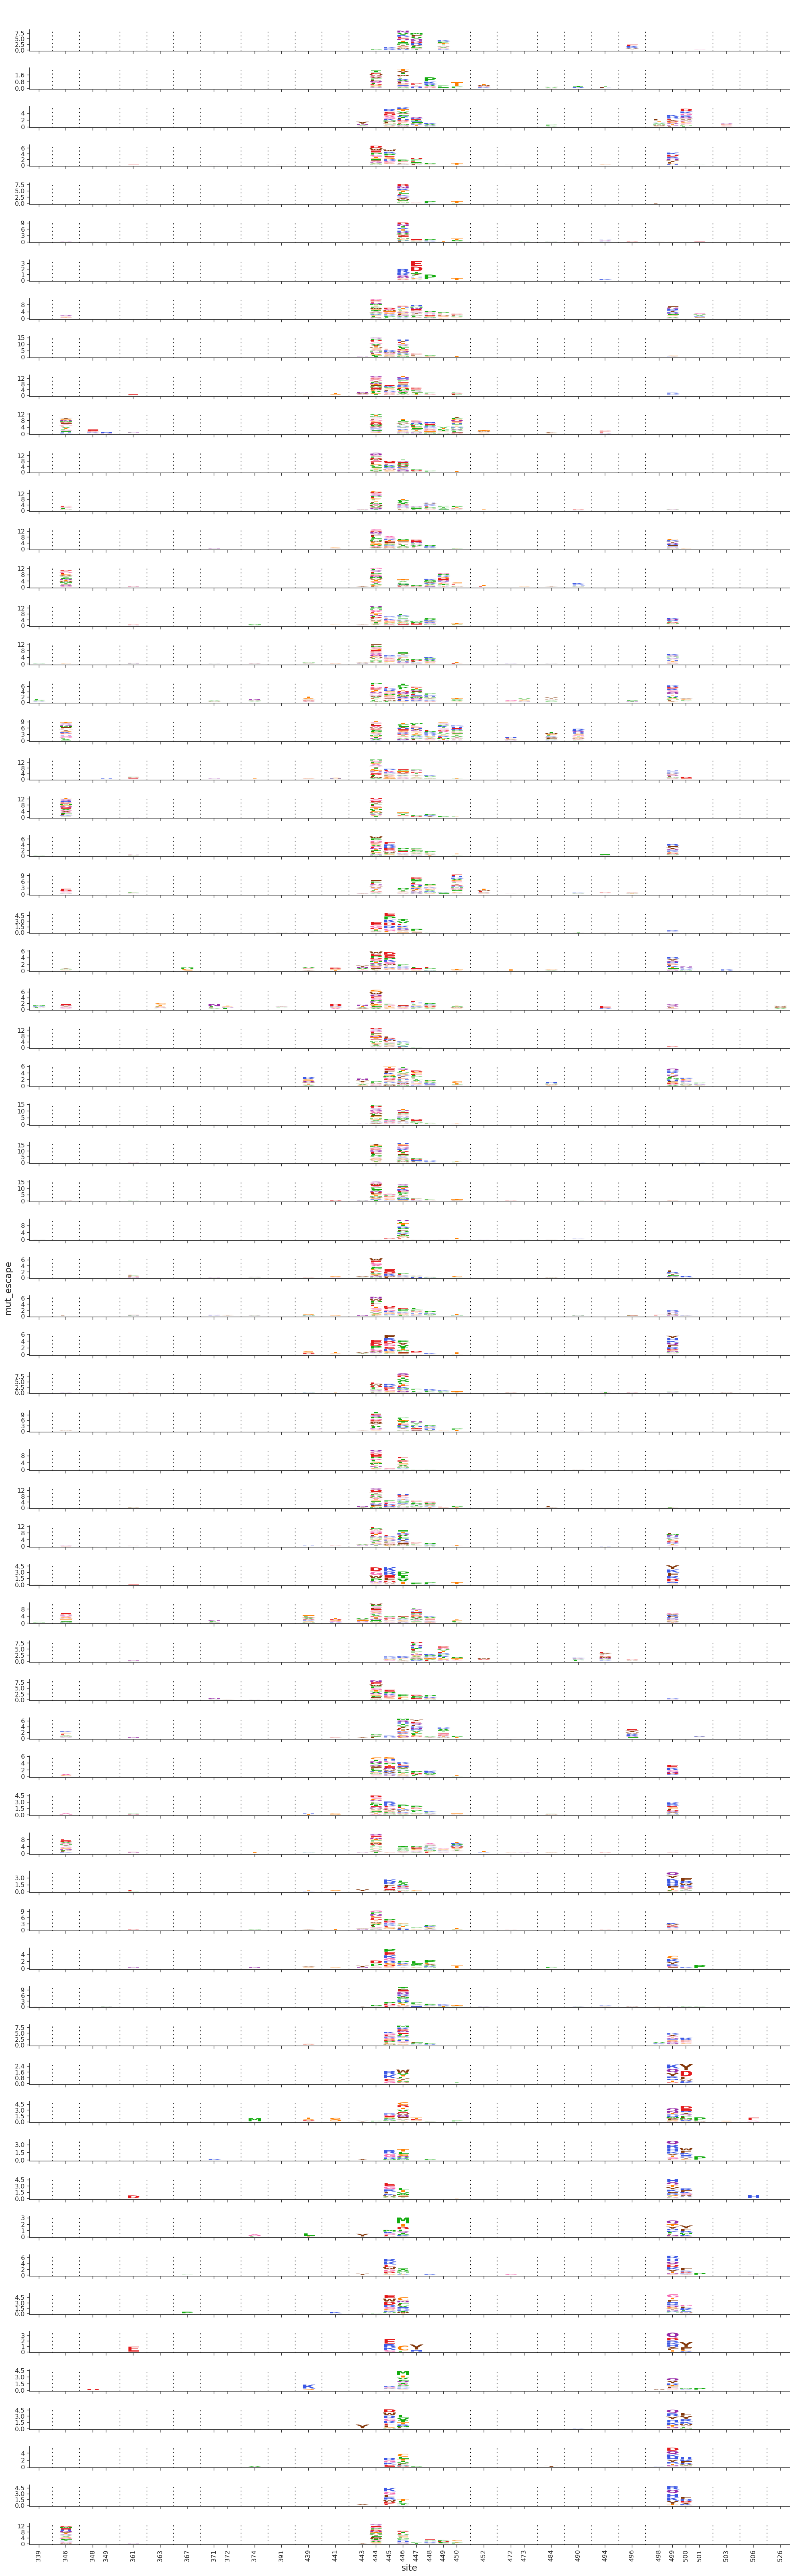

In [ ]:
# Make a list of antibodies to plot
escape_cluster = 5
nabs = 5

random.seed(1)
data = traj_df.drop_duplicates('antibody')
# antibodies_to_plot = random.sample(list(
#     data[
#         (data['epitope_cluster'] == 'E2.2') &
#         (data['escape_cluster'] == escape_cluster)
#     ]['antibody']
# ), nabs)

# Get DMS data, adding entries of zero for missing mutations
data_to_plot = dms_df[dms_df['antibody'].isin(antibodies_to_plot)].copy()
null_dict = defaultdict(list)
for site in data_to_plot['site'].unique():
    for mutation in data_to_plot['mutation'].unique():
        null_dict['site'].append(site)
        null_dict['mutation'].append(mutation)
        null_dict['mut_escape'].append(0.0)
null_df = pd.DataFrame(null_dict)
dfs = []
for (ab, ab_data) in data_to_plot.groupby('antibody'):
    null_data = null_df.copy()
    null_data['antibody'] = ab
    ab_data = (
        pd.concat([null_data, ab_data])
        .groupby(['antibody', 'site', 'mutation'], as_index=False)['mut_escape'].sum()
    )
    dfs.append(ab_data)
data_to_plot = pd.concat(dfs)

# Identify which sites to plot
site_data = data_to_plot.groupby(['antibody', 'site'], as_index=False)['mut_escape'].sum()
sites_to_plot = list(site_data[site_data['mut_escape'] > 1]['site'])
data_to_plot = data_to_plot[data_to_plot['site'].isin(sites_to_plot)]

# Make plot
(fig, axes) = dmslogo.facet_plot(
    data_to_plot,
    gridrow_col="antibody",
    x_col="site",
    show_col=None,
    share_ylim_across_rows=False,
    #draw_line_kwargs=dict(height_col="totfracsurvive", xtick_col="site"),
    draw_logo_kwargs=dict(
        letter_col="mutation", letter_height_col="mut_escape",
        xlabel="site",
    ),
    height_per_ax=1, # Omar: you can change this number to make the plots bigger vertically
    #line_titlesuffix="site-level selection",
    #logo_titlesuffix="mutation-level selection",
)
for ax in axes:
    ax[0].set(title='') # Omar: you can remove this loop to include ab titles
plt.show()

In [ ]:
data_to_plot = dms_df[dms_df['group'].isin(groups_to_plot)]

# Add entries of zero for missing mutations
null_dict = defaultdict(list)
for site in data_to_plot['site'].unique():
    for mutation in data_to_plot['mutation'].unique():
        null_dict['site'].append(site)
        null_dict['mutation'].append(mutation)
        null_dict['normalized_mut_escape'].append(0.0)
null_df = pd.DataFrame(null_dict)
dfs = []
for ((group, ab), ab_data) in data_to_plot.groupby(['group', 'antibody']):
    null_data = null_df.copy()
    null_data['group'] = [group] * len(null_data)
    null_data['antibody'] = ab
    ab_data = (
        pd.concat([null_data, ab_data])
        .groupby(['group', 'antibody', 'site', 'mutation'], as_index=False)['normalized_mut_escape'].sum()
    )
    dfs.append(ab_data)
data_to_plot = pd.concat(dfs)

# Get average normalized mutation-level escape scores
data_to_plot = (
    data_to_plot
    .groupby(['group', 'site', 'mutation'], as_index=False)
    .agg(
        mean_normalized_mut_escape = ('normalized_mut_escape', 'mean'),
    )
    .assign(group_title = lambda x: x['group'].map(lambda y: f'cluster {y[0]}, epitope {y[1]}'))
)
data_to_plot['escape_cluster'] = data_to_plot['group'].apply(lambda x: x[0])
data_to_plot = data_to_plot[data_to_plot['group'] == (5, 'E2.2')]

data_to_plot

group  site mutation  mean_normalized_mut_escape  \
21980  (5, E2.2)   331        A                         0.0   
21981  (5, E2.2)   331        C                         0.0   
21982  (5, E2.2)   331        D                         0.0   
21983  (5, E2.2)   331        E                         0.0   
21984  (5, E2.2)   331        F                         0.0   
...          ...   ...      ...                         ...   
25115  (5, E2.2)   530        S                         0.0   
25116  (5, E2.2)   530        T                         0.0   
25117  (5, E2.2)   530        V                         0.0   
25118  (5, E2.2)   530        W                         0.0   
25119  (5, E2.2)   530        Y                         0.0   

                   group_title  escape_cluster  
21980  cluster 5, epitope E2.2               5  
21981  cluster 5, epitope E2.2               5  
21982  cluster 5, epitope E2.2               5  
21983  cluster 5, epitope E2.2               5  
21984  cluster 5, epitope E2.2               5  
...                        ...             ...  
25115  cluster 5, epitope E2.2               5  
25116  cluster 5, epitope E2.2               5  
25117  cluster 5, epitope E2.2               5  
25118  cluster 5, epitope E2.2               5  
25119  cluster 5, epitope E2.2               5  

[3140 rows x 6 columns]

In [ ]:
data = (
    ic50s_df
    .drop_duplicates('antibody')[['antibody', 'escape_cluster', 'epitope_cluster']]
    .merge(site_escape_df[['antibody', 'site', 'normalized_escape']], on='antibody')
    .merge(mut_freq_df.groupby('site', as_index=False)['mut_freq'].max(), on='site', how='inner')
)
data = data[
    (data['escape_cluster'] == 2) &
    #(data['epitope_cluster'] == 'E2.2') &
    #(data['epitope_cluster'] == 'F2') &
    #(data['site'] == 371) &
    (data['normalized_escape'] > 0.1) &
    (data['mut_freq'] > 0.5)
]
antibodies_to_plot = data['antibody'].iloc[:10]
data['site'].value_counts()

452    70
490    53
484    32
346    26
446    21
496    10
445     3
460     1
493     1
498     1
Name: site, dtype: int64

Visualize DMS data of select antibodies

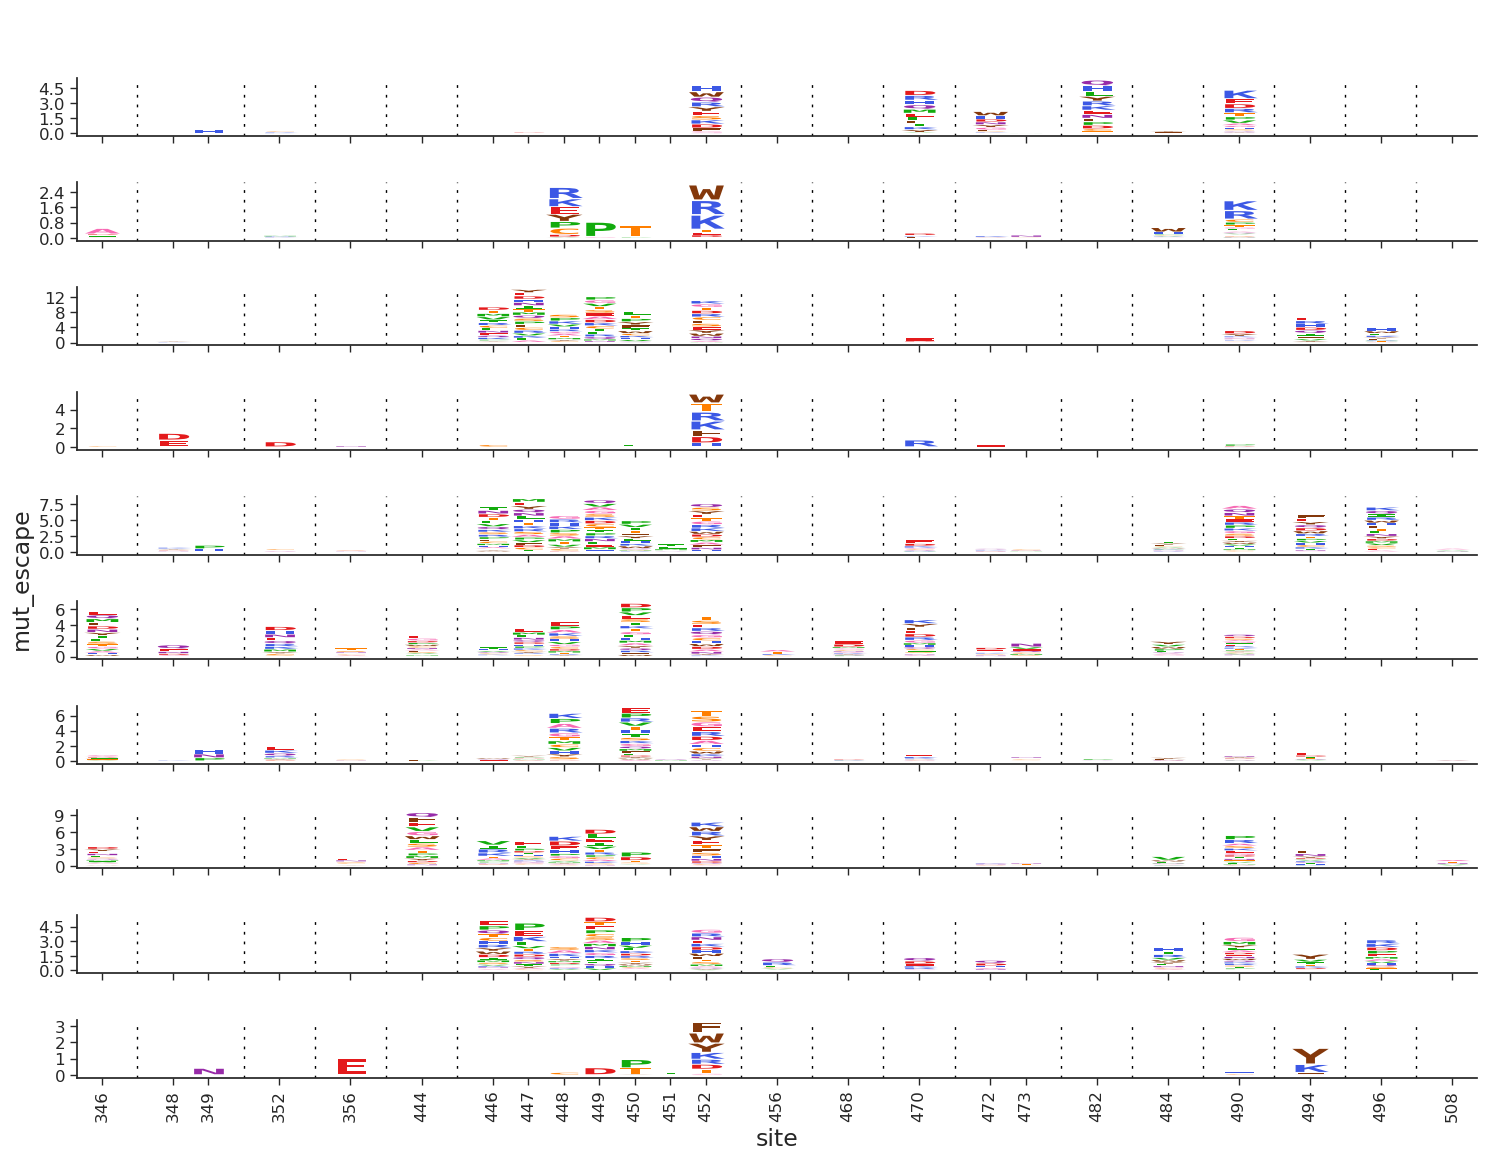

In [ ]:
# Make a list of antibodies to plot
escape_cluster = 5
nabs = 5

random.seed(1)
data = traj_df.drop_duplicates('antibody')
# antibodies_to_plot = random.sample(list(
#     data[
#         (data['epitope_cluster'] == 'E2.2') &
#         (data['escape_cluster'] == escape_cluster)
#     ]['antibody']
# ), nabs)

# Get DMS data, adding entries of zero for missing mutations
data_to_plot = dms_df[dms_df['antibody'].isin(antibodies_to_plot)].copy()
null_dict = defaultdict(list)
for site in data_to_plot['site'].unique():
    for mutation in data_to_plot['mutation'].unique():
        null_dict['site'].append(site)
        null_dict['mutation'].append(mutation)
        null_dict['mut_escape'].append(0.0)
null_df = pd.DataFrame(null_dict)
dfs = []
for (ab, ab_data) in data_to_plot.groupby('antibody'):
    null_data = null_df.copy()
    null_data['antibody'] = ab
    ab_data = (
        pd.concat([null_data, ab_data])
        .groupby(['antibody', 'site', 'mutation'], as_index=False)['mut_escape'].sum()
    )
    dfs.append(ab_data)
data_to_plot = pd.concat(dfs)

# Identify which sites to plot
site_data = data_to_plot.groupby(['antibody', 'site'], as_index=False)['mut_escape'].sum()
sites_to_plot = list(site_data[site_data['mut_escape'] > 1]['site'])
data_to_plot = data_to_plot[data_to_plot['site'].isin(sites_to_plot)]

# Make plot
(fig, axes) = dmslogo.facet_plot(
    data_to_plot,
    gridrow_col="antibody",
    x_col="site",
    show_col=None,
    share_ylim_across_rows=False,
    #draw_line_kwargs=dict(height_col="totfracsurvive", xtick_col="site"),
    draw_logo_kwargs=dict(
        letter_col="mutation", letter_height_col="mut_escape",
        xlabel="site",
    ),
    height_per_ax=1, # Omar: you can change this number to make the plots bigger vertically
    #line_titlesuffix="site-level selection",
    #logo_titlesuffix="mutation-level selection",
)
for ax in axes:
    ax[0].set(title='') # Omar: you can remove this loop to include ab titles
plt.show()